# Uncertainty Prediction and Evaluation For Regression Neural Networks: Comparing Multiple Models Using a Single Dataset
In this notebook, we evaluate and score different fully-connected 
neural network uncertainty models. \
To do this, we use a sample dataset with a single input feature and single target.

<br>You can specify which models to compare by including them in the MODEL_TYPE_LIST.  \
There are five different model options:
 - Probability Distribution Prediction with a Normal Distribution (pdp_norm)
 - Probability Distribution Prediction with the SinH-ArcSinH Distribution (pdp_sinh)
 - Ensemble Prediction with the Continuous Ranked Probability Score (CRPS) Loss Function (ep_crps)
 - Monte-Carlo Dropout
    * MAE Loss (mc_dropa)
    * MSE Loss (mc_drops)

<br>You can select which dataset to evaluate the models by changing the DATA_TYPE. \
There are six different datasets to select from:
  - Linear Increasing Mean with Normally Distributed Spread (normal)
  - Linear Increasing Mean with Log-Normal Distributed Spread (lognorm)
  - Linear Increasing Mean with Linear Heteroscedastic Spread (hetlin)
  - Linear Decreasing Mean with Non-Linear Heteroscedastic Spread (hetnon)
  - Linear Decreasing Mean with Non-Linear Non-Gaussian Spread (hetnon2)
  - Exponential Increasing Mean with Increasing Spread (gamma)
  - Exponential and Point Mass Distributions (gammap)

<br> For evaluation, you have the option to plot five different graphics:
 - Cumulative Distribution Function (CDF) showing the CRPS
 - Attributes Diagram
 - Spread-Skill Plot
 - Discard Test
 - Probability Integral Transform (PIT) Diagram

<br> For model comparisons, we will utilize eight different scores: 
 - Continuous Rank Probability Score (CRPS)
 - Mean Squared Error Skill Score (MSESS)
 - Spread Skill Ratio (SSRAT)
 - Spread Skill Reliability (SSREL)
 - PIT Calibration Deviation Metric (PITD)
 - Discard Test Monotinicity Fraction (DMF)
 - Discard Test Improvement (DI)
 - Ignorance Score (IGN)

<br> This notebook combines work from: <br>
- Barnes, E.A., R.J. Barnes, and N. Gordillo, 2021: Adding uncertainty to neural network regression tasks in the geosciences, *arXiv preprint arXiv:2109.07250.* 
- Brey, S.J., 2021: A package for making and working with probabilistic predictions.  Github, https://github.com/TheClimateCorporation/ensemble/. 
- Lagerquist, R., D. Turner, I. Ebert-Uphoff, J. Stewart, and V. Hagerty, V., 2021: Using Deep Learning to Emulate and Accelerate a Radiative Transfer Model. *Journal of Atmospheric and Oceanic Technology*, <b>38</b>(10), pp.1673-1696, https://doi.org/10.1175/MWR-D-21-0096.1. 
- Nipen, T. and R. Stull, 2011: Calibrating probabilistic forecasts from an NWP model.  *Tellus*, <b>63A</b>, pp.858-875, https://doi.org/10.1111/j.1600-0870.2011.00535.x.

<br> Contact: <br>
Kathy Haynes (katherine.haynes@colostate.edu) <br>
Cooperative Institute for Research in the Atmosphere (CIRA) <br>
November 2022

## Import Libraries

In [159]:
import copy
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import shapely.geometry
import tensorflow as tf
import tensorflow_probability as tfp
import time

from descartes import PolygonPatch
from pandas import DataFrame
from properscoring import crps_ensemble
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from IPython.display import display

## User Options

In [160]:
DATA_TYPE = 'hetnon2'
plotData = True
saveData = False

In [161]:
MODEL_TYPE_LIST = ['pdp_norm', 'pdp_sinh', 'ep_crps', 'mc_drops']

showSummary = True
plotLoss = True
saveLoss = False

plotPredictions = True
savePredictions = False

plotUQ = True
saveUQ = False

In [162]:
plotCRPS = True
saveCRPS = False

plotAttributes = True
saveAttributes = False
verboseAttr = False
r2ShowAttr = False

plotSpreadSkill = True
saveSpreadSkill = False
verboseSpreadSkill = False
r2ShowSpreadSkill = False

plotDiscard = True
saveDiscard = False

plotPIT = True
savePIT = False

In [163]:
modelCompEval = True

## Define Default Parameters

### Evaluation Parameters
Default values used by the evaluation metrics.

In [164]:
PIT_BIN_EDGES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### Model Parameters
All of the model options are specified in a dictionary.  These are currently set to defaults that will work for all model type selections.

In [165]:
# Model Options
MC_NTRIALS = 30  # Number of CRPS and Dropout ensemble members 
N_EPOCHS = 150   # Maximum number of epochs to run (model uses early stopping)
STANDARDIZEX = True # Standardize the input features?
STANDARDIZEY = True # Standardize the output targets?
modelOpts = {
    'exRef': 'UQ_Model',
    'network': 'NeuralNetwork',
    'activation_dense': 'relu',
    'batchnorm_flag': False,
    'bias_flag': True,
    'bias_init': 'zeros',
    'bias_reg': None,
    'dropout_flag': False,
    'dropout_dense_last': 0.5,
    'dropout_dense_list': [0.0, 0.1, 0.2],
    'kernel_init': 'glorot_uniform',
    'kernel_reg': None,
    'kernel_reg_lval': 0.01,
    'n_dense_list': [100, 100, 100],
    'seed': None,
    'standardizeX': STANDARDIZEX,
    'standardizeY': STANDARDIZEY,
    'uq_n_members': MC_NTRIALS}
runOpts = {
    'batch_size': 128,
    'epochs': N_EPOCHS,
    'learning_rate': 0.0001,
    'optimizer': 'adam',
    'patience': 4}
expUQ = {'modelOpts': modelOpts,
         'runOpts': runOpts}

### Plot Parameters

In [166]:
MODEL_COLOR_LIST = [\
    'mediumseagreen', 'darkorange', 
    'mediumslateblue', 'deeppink', 
    'limegreen', 'darkviolet']
DATA_COLOR = 'tab:brown'

DATA_TRAIN_COLOR = 'y'
DATA_TEST_COLOR = 'tab:blue'
DATA_TRAIN_SIZE = 5
DATA_TEST_SIZE = 1
ENS_COLOR = 'tab:cyan'

DATA_ALPHA = 0.5
DATA_SIZE = 4
ENS_ALPHA = 0.3
LINE_WIDTH = 2
FONT_SIZE = 14

## Define Functions
This notebook utilizes a variety of functions, which are all defined here to have them consolidated in a central location.

### Data Functions

In [167]:
def create_ahetnon():
    N = 25000  # number of samples
    muMult = 2.
    muOffset = 1.
    x_min = 0
    x_max = 10

    xSeed = 12345
    np.random.seed(xSeed)
    x_NN = np.float32(np.random.uniform(x_min, x_max, N))
    x_Norm = (x_NN - x_NN.min()) / (x_NN.max() - x_NN.min())
    mu = muMult * x_NN + muOffset
    mu_non = 2.75 * np.sin(x_Norm * 0.2 * np.pi) - mu
    sigma_non = 0.6 + 0.4 + np.cos(x_Norm * 3 * np.pi)
    y_NN = np.random.normal(loc=mu_non, scale=sigma_non, size=N)

    tryB = [6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0]
    tryMuBase = -12
    trySigma = [1.3, 1.3, 1.3, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    trySkew = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.1, 1.1, 1.1, 1.1]
    tryTail = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
    for i in range(len(trySigma)):
        rPoints = np.where(np.logical_and(
            x_NN >= tryB[i], x_NN <= tryB[i + 1]))
        nPts = rPoints[0].size
        sinh_mu = tryMuBase - trySigma[i]
        sinh_sigma = trySigma[i]
        sinh_skew = trySkew[i]
        sinh_tail = tryTail[i]
        cond_dist = tfp.distributions.SinhArcsinh(\
            sinh_mu, sinh_sigma, sinh_skew, sinh_tail)
        newPoints = cond_dist.sample(nPts).numpy()
        y_NN[rPoints] = newPoints

    rPoints = np.where(np.logical_and(x_NN >= 7., x_NN <= 8.))
    nPts = rPoints[0].size
    sinh_mu = tryMuBase - 2.
    sinh_sigma = 2.0
    sinh_skew = 1.1
    sinh_tail = 0.8
    cond_dist = tfp.distributions.SinhArcsinh(\
        sinh_mu, sinh_sigma, sinh_skew, sinh_tail)
    newPoints = cond_dist.sample(nPts).numpy()
    y_NN[rPoints] = newPoints

    tryB = [8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9,
            9, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.]
    tryMuBase = -13
    tryMuAdjust = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                   1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    trySigma = [2.0, 1.8, 1.6, 1.4, 1.2, 1.2, 1.2, 0.8, 0.8, 0.6,
                0.6, 0.6, 0.5, 0.5, 0.4, 0.4, 0.3, 0.2, 0.2, 0.1]
    trySkew = [1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2,
               0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    tryTail = [0.8, 0.9, 1, 1, 1, 1, 1, 1, 1, 1,
               1.0, 1.0, 1, 1, 1, 1, 1, 1, 1, 1]
    for i in range(len(trySigma)):
        rPoints = np.where(np.logical_and(
            x_NN >= tryB[i], x_NN <= tryB[i + 1]))
        nPts = rPoints[0].size
        sinh_mu = tryMuBase - tryMuAdjust[i]
        sinh_sigma = trySigma[i]
        sinh_skew = trySkew[i]
        sinh_tail = tryTail[i]
        cond_dist = tfp.distributions.SinhArcsinh(\
            sinh_mu, sinh_sigma, sinh_skew, sinh_tail)
        newPoints = cond_dist.sample(nPts).numpy()
        y_NN[rPoints] = newPoints

    return x_NN, y_NN

In [168]:
# Create the dataset.
def create_dataset(data_type,
                   n_data=25000,
                   muMult=2., muOffset=1., 
                   point_mass_frac=0.2, point_mass_value=10.,
                   sigma=0.75,
                   test_fraction=0.2,
                   x_min=0, x_max=10):
  
  # Create x-values using a random uniform distribution
  X_all = np.float32(np.random.uniform(x_min, x_max, n_data))
  X_allNorm = (X_all - X_all.min()) / (X_all.max() - X_all.min())

  # Create y-values using specified distributions
  n_target=1
  Y_all = np.empty((n_data, n_target))
  
  mu = muMult * X_all + muOffset

  for t in range(n_target):
      if data_type == 'normal':
        Y_all[:, t] = np.random.normal(loc=mu, scale=sigma, size=n_data)
        yTitle = 'Normal Spread'
        tTitle = 'Normal'
      elif data_type == 'lognorm':
        sig_a = np.log(1 + (sigma**2 / mu**2))
        mu_a = np.log(mu) - sig_a / 2
        Y_all[:, t] = np.random.lognormal(
            mean=mu_a, sigma=np.sqrt(sig_a), size=n_data)
        yTitle = 'Log-Normal Spread'
        tTitle = 'Log-Normal'
      elif data_type == 'hetlin':
        sigma_2 = 0.6 + 0.4 + np.cos(X_allNorm * 3 * np.pi)
        Y_all[:, t] = np.random.normal(loc=mu, scale=sigma_2, size=n_data)
        yTitle = 'Linear Heteroscedastic'
        tTitle = 'Linear'
      elif data_type == 'hetnon':
        mu_non = 2.75 * np.sin(X_allNorm * 0.2 * np.pi) - mu
        sigma_2 = 0.6 + 0.4 + np.cos(X_allNorm * 3 * np.pi)
        Y_all[:, t] = np.random.normal(loc=mu_non, scale=sigma_2, size=n_data)
        yTitle = 'Non-Linear Heteroscedastic'
        tTitle = 'Non-Linear'
      elif data_type == 'hetnon2':
        X_all, Y_all[:, t] = create_ahetnon()
        yTitle = 'Non-Linear Non-Gaussian'
        tTitle = 'Non-Gaussian'
      elif data_type == 'gamma':
        r_gamma = np.array([np.random.gamma(shape=i, scale=i) for i in X_all])
        Y_all[:, t] = np.float32(np.power(X_all, 3.15) + r_gamma * 4.0) / 100.
        yTitle = 'Exponential Distribution'
        tTitle = 'Gamma'
      elif data_type == 'gammap':
        r_gamma = np.array([np.random.gamma(shape=i, scale=i) for i in X_all])
        miles = np.float32(np.power(X_all, 3.15) + r_gamma * 4.0) / 100.
        n_pointmass = int(point_mass_frac * n_data)
        replace_ind = np.random.randint(0, n_data, n_pointmass)
        miles[replace_ind] = point_mass_value
        Y_all[:, t] = miles
        yTitle = 'Exponential Point Mass'
        tTitle = 'Point'
      else:
        print("Unknown DATA_TYPE: {}".format(data_type))
        Y_all[:, t] = 1.0
        yTitle = 'Constant'
        tTitle = 'Constant'

  if len(X_all.shape) < 2:
      X_all = X_all.reshape(-1, 1)
  X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_all, test_size=test_fraction)
  return X_train, X_test, Y_train, Y_test, yTitle, tTitle

### Distribution UQ Helper Functions
Helper functions are required in order to unscale the predictions that predict distribution parameters.  \
Here we have the helper functions for the normal and sinh-arcsinh distributions. 

In [169]:
def _jones_pewsey_P(q):
    """ P_q function from page 764 of [1].
    This is a module private helper function.
    This function will not be called externally.

    Arguments
    ---------
    q : float or double , array like
    Returns
    -------
    P_q : array like of same shape as q.

    Notes
    -----
    * The strange constant 0.25612... is "sqrt(sqrt(e) / (8* pi))"
    computed with a high-precision calculator.
    """

    return 0.25612601391340369863537463 * (
        scipy.special.kv((q + 1) / 2, 0.25)
        + scipy.special.kv((q - 1) / 2, 0.25))

In [170]:
def create_sample_norm_tfp(mu, sigma,
                           nSamples=2000,
                           Ymeans=None,
                           Ystds=None):
    cond_dist = tfp.distributions.Normal(mu, sigma)
    sample = cond_dist.sample(nSamples).numpy()
    if (Ymeans is not None) and (Ystds is not None):
        sample = sample * Ystds + Ymeans
    sample = np.moveaxis(sample, 0, -1)
    return sample

In [171]:
def create_sample_sinh_tfp(
        mu, sigma, gamma, tau,
        nSamples=2000,
        Ymeans=None, Ystds=None):
    cond_dist = tfp.distributions.SinhArcsinh(
        mu, sigma, gamma, tau)
    sample = cond_dist.sample(nSamples).numpy()
    if (Ymeans is not None) and (Ystds is not None):
        sample = sample * Ystds + Ymeans
    sample = np.moveaxis(sample, 0, -1)
    return sample

In [172]:
def normal_unscale_tf(mu, sigma, YMeans, YStds,
                      nSamples=100,
                      uqLow=2.5, uqHigh=97.5):

    cond_dist = tfp.distributions.Normal(mu, sigma)
    sample_scaled = cond_dist.sample(nSamples).numpy()
    sample = YStds * sample_scaled + YMeans

    pmean = np.mean(sample, axis=0)
    pmedian = np.median(sample, axis=0)
    pstd = np.std(sample, axis=0)
    pmin = np.percentile(sample, uqLow, axis=0)
    pmax = np.percentile(sample, uqHigh, axis=0)

    return pmean, pmedian, pstd, pmin, pmax

In [173]:
def sinh_mean(mu, sigma, gamma, tau):
    """ The distribution mean.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double (batch size x 1) Tensor
        The tail - weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    NOTE: I HAVE CONVERTED THESE TO NUMPY.
          TO GET BACK TO TENSORS REPLACE "np."
             WITH "tf.math."

    Returns
    -------
    x: float or double (batch size x 1) Tensor.
    The computed distribution mean values .
    """
    evX = np.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
    return mu + sigma * evX

In [174]:
def sinh_median(mu, sigma, gamma, tau):
    """ The distribution median.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double (batch size x 1) Tensor
        The scale parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double ( batch size x 1) Tensor
        The tail-weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values .

    Notes
    -----
    * This code uses the basic formula :
        E(a*X + b) = a*E(X) + b
    * The E(X) is computed using the moment equation given
        on page 764 of [1].
    """
    return mu + sigma * np.sinh(gamma / tau)

In [175]:
def sinh_max(mu, sigma, gamma, tau,
             nsamples=10000,
             uqHigh=97.5,
             YMeans=None, YStds=None):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample = cond_dist.sample(nsamples).numpy()
    if (YMeans is not None) and (YStds is not None):
        sample = sample * YStds + YMeans
    return np.percentile(sample, uqHigh, axis=0)

In [176]:
def sinh_min(mu, sigma, gamma, tau,
             nsamples=10000,
             uqLow=2.5,
             YMeans=None, YStds=None):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample = cond_dist.sample(nsamples).numpy()
    if (YMeans is not None) and (YStds is not None):
        sample = sample * YStds + YMeans

    return np.percentile(sample, uqLow, axis=0)

In [177]:
def sinh_stddev(mu, sigma, gamma, tau):
    """ The distribution standard deviation.

    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    sigma : float or double ( batch size x 1) Tensor
        The scale parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.
    gamma : float or double (batch size x 1) Tensor
        The skewness parameter.
        Must be the same shape and dtype as mu.
    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter.
        Must be strictly positive.
        Must be the same shape and dtype as mu.

    NOTE: These are converted to numpy.
          To get back to tensors, replace
          "np" with "tf.math"
          
    Returns
    -------
    x : The computed distribution standard-deviations.
    """

    evX = np.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
    evX2 = (np.cosh(2 * gamma / tau)
            * _jones_pewsey_P(2.0 / tau) - 1.0) / 2
    variance = np.square(sigma) * (evX2 - np.square(evX))
    return np.sqrt(variance)

In [178]:
def sinh_unscale_tf(mu, sigma, gamma, tau, YMeans, YStds,
                    nSamples=100,
                    uqLow=2.5, uqHigh=97.5):

    cond_dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
    sample_scaled = cond_dist.sample(nSamples).numpy()
    sample = YStds * sample_scaled + YMeans

    pmean = np.mean(sample, axis=0)
    pmedian = np.median(sample, axis=0)
    pstd = np.std(sample, axis=0)
    pmin = np.percentile(sample, uqLow, axis=0)
    pmax = np.percentile(sample, uqHigh, axis=0)

    return pmean, pmedian, pstd, pmin, pmax

### Generic Helper Functions

In [179]:
def create_contours(minVal, maxVal, nContours, match=False):
    if match:
        xVal = np.max([np.abs(minVal), np.abs(maxVal)])
        interval = 2 * xVal / (nContours - 1)
    else:
        interval = (maxVal - minVal) / (nContours - 1)
    contours = np.empty((nContours))
    for i in range(nContours):
        contours[i] = minVal + i * interval
    return contours

In [180]:
def find_nearest(array, value, smaller=False, larger=False):
    if larger:
        # The implementation below is used so that when a value is halfway
        # between two points, the larger index is returned (like infind)
        return len(array) - np.abs((array - value))[::-1].argmin() - 1
        
    if smaller:
        return np.where(array <= value)[0][-1]
    
    return (np.abs(array - value)).argmin()

In [181]:
def get_centers(xvals):
    centers = [xvals[j] + (xvals[j + 1] - xvals[j]) * 0.5
               for j in range(len(xvals) - 1)]
    return centers

In [182]:
def get_edges(xvals):
    cmid = [xvals[j] - (xvals[j + 1] - xvals[j]) * 0.5
            for j in range(len(xvals) - 1)]
    c1 = [xvals[-1] - (xvals[-1] - xvals[-2]) * 0.5]
    c2 = [xvals[-1] + (xvals[-1] - xvals[-2]) * 0.5]
    return np.array(cmid + c1 + c2)

In [183]:
def get_histogram(var, bins=10, density=False, weights=None):
    counts, bin_edges = np.histogram(
        var, bins=bins, density=density, weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return counts, bin_centers

In [184]:
def get_min_max(var1, var2):
    myMin = np.min([var1.min(), var2.min()])
    myMax = np.max([var1.max(), var2.max()])
    return myMin, myMax

In [185]:
def list_every_x_empty(lst1, x=4):
    myList = lst1.copy()
    for i in range(len(lst1)):
        if (i % x) != 0:
            myList[i] = ''
    return myList

In [186]:
def list_pull_valid(list1, list2=None,
                    badVal=-999):

    refs = []
    for i in range(len(list1)):
        if list1[i] > badVal:
            refs.append(i)

    if list2 is not None:
        return list1[refs], list2[refs]
    else:
        return list1[refs]

In [187]:
def list_replace_valid(list1, list2=None,
                    badVal=-999, replaceVal=0):

    list1_out = list1.copy()
    if list2 is not None:
        list2_out = list2.copy()
    for i in range(len(list1)):
        if list1[i] <= badVal:
            list1_out[i] = replaceVal
            if list2 is not None:
                list2_out[i] = replaceVal

    if list2 is not None:
        return list1_out, list2_out
    else:
        return list1_out

In [188]:
def list_to_int(input_list):
    out_list = []
    for ele in input_list:
        out_list.append(int(ele))
    return out_list

In [189]:
def list_to_str(input_list, format="%.1f"):
    """ Use format="%d" for an integer"""
    return [format % i for i in input_list]

In [190]:
def vertex_arrays_to_list(vertex_x_coords, vertex_y_coords):
    """Converts vertices of simple polygon from two arrays to one list.

    V = number of vertices

    :param vertex_x_coords: length-V numpy array of x-coordinates.
    :param vertex_y_coords: length-V numpy array of y-coordinates.
    :return: vertex_coords_as_list: length-V list, where each element is an
        (x, y) tuple.
    """

    num_vertices = len(vertex_x_coords)
    vertex_coords_as_list = []

    for i in range(num_vertices):
        vertex_coords_as_list.append((vertex_x_coords[i], vertex_y_coords[i]))

    return vertex_coords_as_list

### Evaluation Metrics

In [191]:
def crps_score(A, B, plotCRPS=False):

    nA = A.size
    asorted = np.sort(A.reshape(-1))
    aproportional = 1. * np.arange(nA) / (nA - 1)

    nB = B.size
    bsorted = np.sort(B.reshape(-1))
    bproportional = 1. * np.arange(nB) / (nB - 1)

    if nB > nA:
        iii = np.linspace(0, nB - 1, num=nA).astype(int)
        bsorted2 = bsorted[iii]
    else:
        bsorted2 = bsorted

    if plotCRPS:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111)
        ax.plot(asorted, aproportional, color='black')
        ax.plot(bsorted, bproportional, color='mediumseagreen')
        fig.show()
        
    dp = aproportional[2] - aproportional[1]
    score = np.sum(np.abs(np.subtract(asorted, bsorted2))) * dp
    return score

In [192]:
def ignorance_score(ytrue, ymean, ystd, 
    plotPDF=False, nBins=10, probMin=0.0001):
    
    nPts = ytrue.shape[0]
    if len(ytrue.shape) > 1:
        ytrue = ytrue.reshape(-1)
    if len(ymean.shape) > 1:
        ymean = ymean.reshape(-1)
    if len(ystd.shape) > 1:
        ystd = ystd.reshape(-1)
    ymin = ymean - 3. * ystd
    ymax = ymean + 3. * ystd

    ign_score = 0.
    for i in range(nPts):
        minH = ymin[i]
        maxH = ymax[i]
        trueH = ytrue[i]
        if trueH >= minH and trueH <= maxH:
            bin_edges = np.array([value for value in np.linspace(
                minH, maxH, num=nBins + 1)])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            indx = find_nearest(bin_centers, trueH)

            dist = scipy.stats.norm(ymean[i], ystd[i])
            probability = dist.pdf(bin_centers[indx])
            ign_score += np.log2(probability)

            if plotPDF and i == 0:
                probabilities = [dist.pdf(value) for value in bin_centers]
                plt.plot(bin_centers, probabilities)
                plt.xlabel('Target Value')
                plt.ylabel('Density')
                plt.show()
        else:
            ign_score += np.log2(probMin)

    ign_score = -1. * ign_score / nPts
    return ign_score

In [193]:
def ignorance_score_ens(ytrue, ypred, 
    nBins=10, plotPDF=False, probMin=0.0001):
    nPts = ytrue.size

    ytrue = ytrue.reshape(-1)
    ymean = np.mean(ypred, axis=-1).reshape(-1)
    ystd = np.std(ypred, axis=-1).reshape(-1)
    ymin = ymean - 3. * ystd
    ymax = ymean + 3. * ystd

    ign_score = 0.
    for i in range(nPts):
        minH = ymin[i]
        maxH = ymax[i]
        trueH = ytrue[i]

        if trueH >= minH and trueH <= maxH:
            bin_edges = [value for value in np.linspace(\
                minH, maxH, num=nBins + 1)]
            density, bin_centers = get_histogram(\
                ypred[i, :], bins=bin_edges, density=True)
            indx = find_nearest(bin_centers, trueH)
            probability = np.max([density[indx], probMin])
            ign_score += np.log2(probability)

            if plotPDF and i == 0:
                plt.plot(bin_centers, density)
                plt.xlabel('Target Value')
                plt.ylabel('Density')
        else:
            ign_score += np.log2(probMin)

    ign_score = -ign_score / nPts
    return ign_score

In [194]:
def mse(A, B):
    return np.mean((A - B)**2)

In [195]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

### Evaluation Functions

In [196]:
def get_attributes_points(y_true, y_pred,
                           bin_edges=None,
                           min_val=None,
                           max_val=None,
                           mean_val=None,
                           nBins=10,
                           showR2=True,
                           nTicks=5,
                           verbose=True):

    if min_val is None or max_val is None:
        min_val, max_val = get_min_max(y_pred, y_true)

    if mean_val is None:
        mean_val = y_true.mean()

    if bin_edges is None:
        bin_edges = create_contours(min_val, max_val, nBins + 1)

    pred_vals = np.zeros((nBins)) - 999.
    obs_vals = np.zeros((nBins)) - 999.
    y_on_pred = np.zeros((y_pred.shape)) - 999.
    for i in range(nBins):
        gref = np.logical_and(\
            y_pred >= bin_edges[i],
            y_pred < bin_edges[i + 1])
        if np.any(gref):
            pred_vals[i] = np.mean(y_pred[gref])
            obs_vals[i] = np.mean(y_true[gref])
            y_on_pred[gref] = y_true[gref]

    obs_counts, obs_bins = get_histogram(
        y_true, bins=bin_edges)
    pred_counts, pred_bins = get_histogram(
        y_pred, bins=bin_edges)

    yclimo = np.ones_like(y_true) * mean_val
    mseclimo = mse(y_true, yclimo)
    msepred = mse(y_true, y_pred)
    msess = (mseclimo - msepred) / mseclimo

    r2score = r2_score(y_on_pred.reshape(-1), y_pred.reshape(-1))
    corcoef = np.corrcoef(\
        y_pred.reshape(-1), y_on_pred.reshape(-1))[0, 1]
    slope, intercept, rvalue, _, _ = scipy.stats.linregress(\
        y_pred.reshape(-1), y_on_pred.reshape(-1))

    tick_vals = list_to_int(
        np.linspace(min_val, max_val, nTicks))

    if verbose:
        print("Climatology MSE: {:.4f}".format(mseclimo))
        print("Predicted MSE: {:.4f}".format(msepred))
        print("MSE Skill Score (MSESS): {:.4f}".format(msess))
        print("Cond YObs vs. Pred R2 Score: {:.4f}  r2 Value: {:.4f}".\
            format(r2score, rvalue * rvalue))
        print("Cond YObs vs. Pred Pearson's Cor Coef: {:.4f}  r Value: {:.4f}".\
            format(corcoef, rvalue))
        print("Cond YObs Min: {:.3f}, Mean: {:.3f}, Max: {:.3f}".\
            format(y_on_pred.min(), y_on_pred.mean(), y_on_pred.max()))
        print("Pred Min: {:.3f}, Mean: {:.3f}, Max: {:.3f}".\
            format(y_pred.min(), y_pred.mean(), y_pred.max()))

    if showR2:
        mycolor = 'tab:blue'
        linecolor = 'black'
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(y_pred, y_on_pred, 
        alpha=0.6, color=mycolor, s=1)
        ax.set_xlabel("Pred Spread")
        ax.set_ylabel("Error")

        yline1 = min_val * slope + intercept
        yline2 = max_val * slope + intercept
        ax.plot([min_val, max_val], [yline1, yline2], \
            color=mycolor)
        ax.plot([min_val, max_val], [min_val, max_val], 
            color=linecolor, linestyle='--')
        plt.show()

    aDict = {
        'attr_cor_coef': rvalue,
        'attr_min_val': min_val,
        'attr_max_val': max_val,
        'attr_mean_val': mean_val,
        'attr_msess': msess,
        'attr_obs_bins': obs_bins,
        'attr_obs_counts': obs_counts,
        'attr_obs_vals': obs_vals,
        'attr_pred_bins': pred_bins,
        'attr_pred_counts': pred_counts,
        'attr_pred_vals': pred_vals,
        'attr_r2_score': r2score,
        'attr_tick_vals': tick_vals}

    return aDict

In [197]:
def get_discard_points(ytrue, ymean, ystd, 
    bins=None):

    if bins is None:
        nbins = 10
        bins = np.linspace(0., 0.9, nbins)
    else:
        nbins = len(bins)

    ytrue1d = ytrue.reshape(-1)
    ymean1d = ymean.reshape(-1)
    ystd1d = ystd.reshape(-1)
    nsamples = ystd1d.shape[0]

    yrefs = np.argsort(ystd1d)
    ytrueSorted = ytrue1d[yrefs]
    ymeanSorted = ymean1d[yrefs]

    rmseOut = np.empty((nbins))
    for i in range(nbins):
        iCutoff = nsamples - int(nsamples * bins[i])
        ytrueH = ytrueSorted[:iCutoff]
        ymeanH = ymeanSorted[:iCutoff]
        rmseOut[i] = rmse(ytrueH, ymeanH)

    dtiA = np.empty((nbins - 1))
    for i in range(nbins - 1):
        dtiA[i] = (rmseOut[i] - rmseOut[i + 1])

    dtmf = 0.
    for i in range(nbins - 1):
        if rmseOut[i] >= rmseOut[i + 1]:
            indicator = 1.
        else:
            indicator = 0.
        dtmf += indicator
    dtmf *= 1 / (nbins - 1)

    discardDict = {
        'discard_bins': bins,
        'discard_dtis': dtiA,
        'discard_mf': dtmf,
        'discard_imprv': np.mean(dtiA[:-1]),
        'discard_vals': rmseOut}

    return discardDict

In [198]:
def get_pit_dvalue(pit_counts):
    dvalue = 0.
    nbins = pit_counts.shape[0]
    nbinsI = 1./nbins

    pitTot = np.sum(pit_counts)
    pit_freq = np.divide(pit_counts, pitTot)
    for i in range(nbins):
        dvalue += (pit_freq[i] - nbinsI) * (pit_freq[i] - nbinsI)
    dvalue = np.sqrt(dvalue/nbins)
    return dvalue

In [199]:
def get_pit_evalue(nbins, tsamples):
    evalue = (1. - 1./nbins)/(tsamples * nbins)
    return np.sqrt(evalue)

In [200]:
def get_pit_points(y_true, y_pred, y_std,
                   pit_bins=PIT_BIN_EDGES):

    nBins = len(pit_bins) - 1
    nSamples = y_true.size
    pit_values = scipy.stats.norm.cdf(\
      x=y_true, loc=y_pred, scale=y_std).reshape(-1)
    weights = np.ones_like(pit_values) / nSamples
    pit_counts, bin_centers = get_histogram(\
      pit_values, bins=pit_bins, weights=weights)

    pDict = {
      'pit_centers': bin_centers,
      'pit_counts': pit_counts,
      'pit_dvalue': get_pit_dvalue(pit_counts),
      'pit_evalue': get_pit_evalue(nBins, nSamples),
      'pit_values': pit_values,
      'pit_weights': weights}
      
    return pDict

In [201]:
def get_pit_points_ens(ytrue, ypred,
    pit_bins=PIT_BIN_EDGES):
    """
    Program to calculate Probability Integral Transform (PIT)
    points from ensemble predictions.

    Assumes a single target.

    Input:
    ytrue: An array containing the true samples with a single target.
    ypred: An array containing the predictions for a single target,
      with the ensemble members in the last dimension 
      i.e. shape = (..., nEns), nEns = # of ensemble members

    Output:
    Dictionary containing the PIT information.
    """

    nTr = ytrue.size
    nPr = ypred.size
    if nTr == nPr:
        print("Using ensemble version of get_pit_points, ")
        print("   but the predictions are not ensembles.")
        return {}

    nBins = len(pit_bins) - 1
    nEns = ypred.shape[-1]
    nSamples = ytrue.size
    pit_evalue = get_pit_evalue(nBins, nSamples)

    ytrueT = ytrue.reshape(-1)
    ypredT = ypred.reshape((nSamples, nEns))
    ypredTS = np.sort(ypredT, axis=1)

    ytrueTE = np.repeat(
      ytrueT[..., np.newaxis], nEns, axis=-1)
    pred_diff = np.abs(np.subtract(ytrueTE, ypredTS))
    pit_values = np.divide(np.argmin(pred_diff, axis=-1), nEns)
    weights = np.ones_like(pit_values) / nSamples
    pit_counts, bin_centers = get_histogram(\
        pit_values, bins=pit_bins, weights=weights)

    pDict = {
      'pit_centers': bin_centers,
      'pit_counts': pit_counts,
      'pit_dvalue': get_pit_dvalue(pit_counts),
      'pit_evalue': pit_evalue,
      'pit_values': pit_values,
      'pit_weights': weights}
      
    return pDict

In [202]:
def get_spread_skill_points(y_true, y_pred, y_std,
                            nBins=10,
                            bins=None,
                            showR2=True,
                            spread_last=None,
                            verbose=True):

    if y_true.shape != y_pred.shape:
        print("Mismatching shapes:")
        print("   y_true: {}".format(y_true.shape))
        print("   y_pred: {}".format(y_pred.shape))
        return {}
    nPts = y_true.size

    if not bins:
        minBin = np.min([0., y_std.min()])
        maxBin = np.ceil(np.max([rmse(y_true, y_pred), y_std.max()]))
        bins = create_contours(minBin, maxBin, nBins + 1)
    else:
        nBins = len(bins) - 1

    ssRel = 0.
    error = np.zeros((nBins)) - 999.
    spread = np.zeros((nBins)) - 999.
    y_on_error = np.zeros((y_pred.shape)) - 999.
    for i in range(nBins):
        refs = np.logical_and(\
            y_std >= bins[i], y_std < bins[i + 1])
        nPtsBin = np.count_nonzero(refs)
        if nPtsBin > 0:
            ytrueBin = y_true[refs]
            ymeanBin = y_pred[refs]
            error[i] = rmse(ytrueBin, ymeanBin)
            spread[i] = np.mean(y_std[refs])
            y_on_error[refs] = np.abs(y_true[refs] - y_pred[refs])
            ssRel += (nPtsBin/nPts) * np.abs(error[i] - spread[i])

    if spread_last is not None:
        spread[-1] = spread_last
    spread_counts, bin_centers  = get_histogram(\
        y_std, bins=bins)

    ssRatio = np.mean(y_std)/rmse(y_true, y_pred)
    ssr2 = r2_score(y_on_error.reshape(-1), y_std.reshape(-1))
    sscor = np.corrcoef(y_std.reshape(-1), y_on_error.reshape(-1))[0, 1]
    slope, intercept, rvalue, _, _ = scipy.stats.linregress(\
        y_std.reshape(-1), y_on_error.reshape(-1))

    if verbose:
        print("Spread Skill Ratio: {:.4f}".format(ssRatio))
        print("       Reliability: {:.4f}".format(ssRel))
        print("          R2 Score: {:.4f}  r2 Value: {:.4f}".\
            format(ssr2, rvalue * rvalue))
        print("Pearson's Cor Coef: {:.4f}  r Value: {:.4f}".\
            format(sscor, rvalue))
        print("   Cond YError Min: {:.3f}, Mean: {:.3f}, Max: {:.3f}".\
            format(y_on_error.min(), y_on_error.mean(), y_on_error.max()))
        print("      Pred Std Min: {:.3f}, Mean: {:.3f}, Max: {:.3f}".\
            format(y_std.min(), y_std.mean(), y_std.max()))

    if showR2:
        mycolor = 'tab:blue'
        linecolor = 'black'
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(y_std, y_on_error, 
        alpha=0.6, color=mycolor, s=1)
        ax.set_xlabel("Pred Spread")
        ax.set_ylabel("Error")

        yline1 = minBin * slope + intercept
        yline2 = maxBin * slope + intercept
        ax.plot([minBin, maxBin], [yline1, yline2], \
            color=mycolor)
        ax.plot([minBin, maxBin], [minBin, maxBin], 
            color=linecolor, linestyle='--')
        plt.show()

    sDict = {
        'ss_bin_edges': bins,
        'ss_bin_centers': bin_centers,
        'ss_cor_coef': rvalue,
        'ss_error_vals': error,
        'ss_ratio': ssRatio,
        'ss_reliability': ssRel,
        'ss_r2_score': ssr2,
        'ss_spread_counts': spread_counts,
        'ss_spread_vals': spread}
    return sDict

### Loss Functions
In order to quantify uncertainty, several methods require specific loss functions, which are defined here.

In [203]:
def loss_crps(y_true, y_pred):
    """Calculates the Continuous Ranked Probability Score (CRPS)
    for finite ensemble members.
    This implementation is based on the identity:
    .. math::
        CRPS(F, x) = E_F|X - x| - 1/2 * E_F|X - X'|
    where X and X' denote independent random variables drawn from
    the forecast distribution F, and E_F denotes the expectation
    value under F.

    Following the aproach of
    https://github.com/TheClimateCorporation/properscoring
    for the actual implementation.
    Adapted from http://www.cs.columbia.edu/~blei/

    Reference
    ---------
    Tilmann Gneiting and Adrian E. Raftery (2005).
        Strictly proper scoring rules, prediction, and estimation.
        University of Washington Department of Statistics Technical
        Report no. 463R.
        https://www.stat.washington.edu/research/reports/2004/tr463R.pdf
    """

    # Variable names below reference equation terms in docstring above
    term_one = tf.reduce_mean(tf.abs(
        tf.subtract(y_pred, y_true)), axis=-1)
    term_two = tf.reduce_mean(
        tf.abs(
            tf.subtract(tf.expand_dims(y_pred, -1),
                        tf.expand_dims(y_pred, -2))
        ),
        axis=(-2, -1)
    )
    half = tf.constant(-0.5, dtype=term_two.dtype)
    score = tf.add(term_one, tf.multiply(half, term_two))
    score = tf.reduce_mean(score)
    return score

In [204]:
def loss_uq_normal(y_true, y_pred):
    """
    This is the log-probability loss to calculate uncertainty
    with a normal distribution.
    This form predicts the uncertainty mean and standard deviation
    for a normal distribution.
    From Barnes, Barnes, & Gordillo (2021).
    """

    y_pred64 = tf.cast(y_pred, tf.float64)
    y_true64 = tf.cast(y_true, tf.float64)

    # network prediction of the value
    mu = y_pred64[..., 0]

    # network prediction of uncertainty
    std = tf.math.exp(y_pred64[..., 1])

    # normal distribution defined by N(mu,sigma)
    norm_dist = tfp.distributions.Normal(mu, std)

    # compute the log as -log(p)
    loss = -norm_dist.log_prob(y_true64)

    return tf.reduce_mean(loss)

In [205]:
def loss_uq_sinh(y_true, y_pred):
    """
    This is the log-probability loss to calculate uncertainty
    with a sinh-arcsinh normal distribution.
    This form predicts the uncertainty mean,
    standard deviation (scale),
    skewness and tailweight (tau).
    From Barnes, Barnes, & Gordillo (2021).
    """

    mu = tf.cast(y_pred[..., 0], tf.float64)
    std = tf.math.exp(tf.cast(y_pred[..., 1], tf.float64))
    skew = tf.cast(y_pred[..., 2], tf.float64)
    tau = tf.math.exp(tf.cast(y_pred[..., 3], tf.float64))

    cond_dist = tfp.distributions.SinhArcsinh(
        loc=mu, scale=std, skewness=skew, tailweight=tau)
    loss = -cond_dist.log_prob(tf.cast(y_true, tf.float64))

    return tf.reduce_mean(loss)

### Model Setup Functions
Setup helper routines are defined in order to allow for various options of optimizer and loss function.

In [206]:
def setup_loss(loss_f, n_outputs=1):
    """Return loss function and metrics from string option."""

    metrics = []
    if loss_f == 'mae':
        loss = tf.keras.losses.MAE
    elif loss_f == 'mc_dropa':
        loss = tf.keras.losses.MAE
    elif loss_f == 'mc_drops':
        loss = tf.keras.losses.MSE
    elif loss_f == 'ep_crps':
        loss = loss_crps
    elif loss_f == 'mse':
        loss = tf.keras.losses.MSE
    elif loss_f == 'pdp_norm':
        loss = loss_uq_normal
    elif loss_f == 'pdp_sinh':
        loss = loss_uq_sinh
    else:
        print("UNKNOWN LOSS FUNCTION, USING MSE")
        loss = tf.keras.losses.MSE
    return loss, metrics

In [207]:
def setup_optimizer(method, learning_rate):
    """Return optimizer from string options."""
    if method == 'sgd':
        algo = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif method == 'adam':
        algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif method == 'adagrad':
        algo = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif method == 'rmsprop':
        algo = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif method == 'adadelta':
        algo = tf.keras.optimizers.Adadelta(
            learning_rate=learning_rate)
    elif method == 'nadam':
        algo = tf.keras.optimizers.Nadam(
            learning_rate=learning_rate)
    else:
        raise Exception(
            "train: method={method} not a valid optimizer.")
    return algo

### Model Class
Define a NeuralNetwork class that will build, compile, train, and run the models.  The class combines all of the routines for the various uncertainty methods and loss functions so that the basic functions can all be called in a similar fashion. 

In [208]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_outputs,
                 modelOpts):

        erStr = "NeuralNetwork Error:"

        tf.keras.backend.clear_session()

        dropout = modelOpts['dropout_flag']
        dropout_last = modelOpts['dropout_dense_last']
        dropout_list = modelOpts['dropout_dense_list']
        loss_type = modelOpts['loss_type']
        n_hiddens_list = modelOpts['n_dense_list']
        uq_n_members = modelOpts['uq_n_members']

        if not isinstance(n_hiddens_list, list):
            print("{} n_hiddens_list must be a list".format(erStr))
            print("    Using Simple Network With No Hidden Layers.")
            n_hiddens_list = []

        if 'drop' in loss_type:
            dropout = True
        if dropout:
            if len(dropout_list) != len(n_hiddens_list):
                print("{} {}".format(
                    "dropout_list and n_hiddens_list must have same length",
                    erStr))
                defaultDropout = 0.1
                print("   Using Default Dropout Of {}".format(defaultDropout))
                dropout_list = []
                for _ in n_hiddens_list:
                    dropout_list.append(defaultDropout)

        self.history = None
        self.loss_type = loss_type
        self.n_hiddens_list = n_hiddens_list
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.training_time = None
        self.uq_n_members = uq_n_members

        self.XStandardize = modelOpts['standardizeX']
        self.Xmeans = None
        self.Xstds = None
        self.Xmax = None
        self.Xmin = None

        self.YStandardize = modelOpts['standardizeY']
        self.Ymeans = None
        self.Ystds = None
        self.Ymax = None
        self.Ymin = None

        bias_init = modelOpts['bias_init']
        if bias_init == 'random':
            bias_init = tf.keras.initializers.RandomNormal(
                            seed=modelOpts['seed'])

        kernel_init = modelOpts['kernel_init']
        if kernel_init == 'random':
            kernel_init = tf.keras.initializers.RandomNormal(
                            seed=modelOpts['seed'])

        kernel_reg = modelOpts['kernel_reg']
        kernel_reg_lval = modelOpts['kernel_reg_lval']
        if kernel_reg == 'L1' or kernel_reg == 'l1':
            kernel_reg = tf.keras.regularizers.L1(kernel_reg_lval)
        elif kernel_reg == 'L2' or kernel_reg == 'l2':
            kernel_reg = tf.keras.regularizers.L2(kernel_reg_lval)

        # Setup Initial and Hidden Layers
        X = Z = tf.keras.Input(shape=(n_inputs,))
        nLayers = len(n_hiddens_list)
        for i in range(nLayers):
            if 'drop' in loss_type:
                Z = tf.keras.layers.Dropout(
                    dropout_list[i])(Z, training=True)
            elif dropout and dropout_list[i] > 0.0:
                Z = tf.keras.layers.Dropout(dropout_list[i])(Z)

            Z = tf.keras.layers.Dense(
                n_hiddens_list[i],
                activation=modelOpts['activation_dense'],
                use_bias=modelOpts['bias_flag'],
                bias_initializer=bias_init,
                bias_regularizer=modelOpts['bias_reg'],
                kernel_initializer=kernel_init,
                kernel_regularizer=kernel_reg)(Z)
            if modelOpts['batchnorm_flag']:
                Z = tf.keras.layers.BatchNormalization()(Z)

        # Setup Output Layer
        if 'crps' in loss_type:
            if dropout and dropout_last > 0.0:
                Z = tf.keras.layers.Dropout(dropout_last)(Z)
            if n_outputs < 2:
                Y = tf.keras.layers.Dense(
                    uq_n_members,
                    kernel_regularizer=kernel_reg,
                    name="ensemble_members")(Z)
            else:
                Y = tf.keras.layers.Dense(
                    n_outputs,
                    kernel_regularizer=kernel_reg)(Z)
                Y = tf.expand_dims(Y, axis=-1)

                for _ in range(1, uq_n_members):
                    outputT = tf.keras.layers.Dense(
                        n_outputs,
                        kernel_regularizer=kernel_reg)(Z)
                    Y = tf.keras.layers.concatenate(
                        (tf.expand_dims(outputT, axis=-1), Y),
                        axis=-1)

        elif 'drop' in loss_type:
            if dropout_last > 0.0:
                Z = tf.keras.layers.Dropout(dropout_last)(Z, training=True)
            Y = tf.keras.layers.Dense(
                n_outputs,
                kernel_regularizer=kernel_reg,
                name="output")(Z)

        elif 'norm' in loss_type:
            mu_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=bias_init,
                kernel_initializer=kernel_init,
                name="mu_unit")(Z)
            logsigma_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logsigma_unit")(Z)
            Y = tf.keras.layers.concatenate(
                (tf.expand_dims(mu_unit, axis=2),
                 tf.expand_dims(logsigma_unit, axis=2)),
                axis=2, name="output")

        elif 'sinh' in loss_type:
            mu_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=bias_init,
                kernel_initializer=kernel_init,
                name="mu_unit")(Z)
            logsigma_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logsigma_unit")(Z)
            skew_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="skew_unit")(Z)
            logtau_unit = tf.keras.layers.Dense(
                n_outputs, activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="logtau_unit")(Z)
            Y = tf.keras.layers.concatenate(
                (tf.expand_dims(mu_unit, axis=2),
                 tf.expand_dims(logsigma_unit, axis=2),
                 tf.expand_dims(skew_unit, axis=2),
                 tf.expand_dims(logtau_unit, axis=2)),
                axis=2, name="output")

        else:
            Y = tf.keras.layers.Dense(
                n_outputs,
                kernel_regularizer=kernel_reg,
                name="output")(Z)
        
        self.model = tf.keras.Model(
            inputs=X, outputs=Y, name=self.loss_type.upper())
        print("{} setup with {} inputs and {} outputs".format(
            type(self).__name__, self.n_inputs, self.n_outputs))

    def __repr__(self):
        str1 = f'{type(self).__name__}'
        str2 = "\n  n_inputs: {}, n_outputs: {}".\
            format(self.n_inputs, self.n_outputs)
        str3 = "\n  n_hiddens: {}, loss_type: {}".\
            format(self.n_hiddens_list, self.loss_type)
        if self.history:
            str4 = "\n  Training loss is {:.4f} in {:.3f} s.".\
                format(self.history['loss'][-1],
                       self.training_time)
        else:
            str4 = '\n  Network is not trained.'
        return str1 + str2 + str3 + str4

    def _setup_standardize(self, X, Y):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Ymeans is None:
            if len(Y.shape) == 3:
                YHere = Y[..., 0]
            else:
                YHere = Y
            self.Ymeans = YHere.mean(axis=0)
            self.Ystds = YHere.std(axis=0)
            self.Yconstant = self.Ystds == 0
            self.YstdsFixed = copy.copy(self.Ystds)
            self.YstdsFixed[self.Yconstant] = 1

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[..., self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeY(self, Y):
        if len(Y.shape) == 3:
            YHere = Y[..., 0]
        else:
            YHere = Y
        result = (YHere - self.Ymeans) / self.YstdsFixed
        result[..., self.Yconstant] = 0.0

        if len(Y.shape) == 3:
            result = np.concatenate(
                (np.expand_dims(result, axis=2),
                 Y[..., 1:]), axis=2)

        return result

    def _unstandardizeY(self, Ys):
        return self.Ystds * Ys + self.Ymeans

    def compile(self, runOpts):
        """Compile Fully-Connected NN."""

        self.batch_size = runOpts['batch_size']
        self.epochs = runOpts['epochs']
        self.patience = runOpts['patience']
        algo = setup_optimizer(runOpts['optimizer'],
                                   runOpts['learning_rate'])
        loss, metrics = setup_loss(
            self.loss_type,
            n_outputs=self.n_outputs)
        self.model.compile(optimizer=algo, loss=loss,
                           metrics=metrics)

    def train(self, X, T,
              batch_size=None,
              epochs=None,
              patience=None,
              validation=None):
        """Use Keras Functional API to train model"""

        if batch_size is None:
            batch_size = self.batch_size
        if epochs is None:
            epochs = self.epochs
        if patience is None:
            patience = self.patience

        if len(X.shape) < 2:
            X = X.reshape((-1, 1))
        if len(T.shape) < 2:
            T = T.reshape((-1, 1))

        self._setup_standardize(X, T)
        if self.XStandardize:
            X = self._standardizeX(X)
        if self.YStandardize:
            T = self._standardizeY(T)

        if validation is not None:
            try:
                XV = validation[0]
                if len(XV.shape) < 2:
                    XV = XV.reshape((-1, 1))

                TV = validation[1]
                if len(TV.shape) < 2:
                    TV = TV.reshape((-1, 1))

                if self.XStandardize:
                    XV = self._standardizeX(XV)
                if self.YStandardize:
                    TV = self._standardizeY(TV)
                validation = (XV, TV)

            except Exception:
                raise TypeError(
                    'validation must have shape: (X, T)')

        if validation is not None:
            callback = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', min_delta=0.0,
                patience=patience,
                verbose=1, mode='auto',
                restore_best_weights=True)]
        else:
            callback = []

        start_time = time.time()
        self.history = self.model.fit(X, T,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      callbacks=callback,
                                      validation_data=validation,
                                      verbose=0).history
        self.training_time = time.time() - start_time
        return self

    def use(self, X, returnType='uq'):

        # Set to error logging after model is trained
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

        if len(X.shape) < 2:
            X = X.reshape((-1, 1))
        if self.XStandardize:
            X = self._standardizeX(X)

        if 'crps' in self.loss_type:
            preds = self.model.predict(X)
            if self.YStandardize:
                for i in range(self.uq_n_members):
                    preds[..., i] = self._unstandardizeY(preds[..., i])

            pmean = preds.mean(axis=-1)
            pmedian = np.median(preds, axis=-1)
            pmin = preds.min(axis=-1)
            pmax = preds.max(axis=-1)
            pstd = preds.std(axis=-1)
            if self.n_outputs == 1:
                preds = np.expand_dims(preds, axis=1)
                pmean = np.expand_dims(pmean, axis=1)
                pmedian = np.expand_dims(pmedian, axis=1)
                pmin = np.expand_dims(pmin, axis=1)
                pmax = np.expand_dims(pmax, axis=1)
                pstd = np.expand_dims(pstd, axis=1)

            if returnType == 'mc':
                return preds
            elif returnType == 'uq':
                return pmean, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmean, pstd, pmin, pmax
            else:
                return np.median(preds, axis=-1)

        elif 'drop' in self.loss_type:
            nTry = self.uq_n_members
            preds = np.concatenate(
                [np.expand_dims(self.model.predict(X), axis=-1)
                    for _ in range(nTry)], axis=-1)

            if self.YStandardize:
                for i in range(self.uq_n_members):
                    preds[..., i] = self._unstandardizeY(preds[..., i])
                    
            pmean = preds.mean(axis=-1)
            pmedian = np.median(preds, axis=-1)
            pmin = preds.min(axis=-1)
            pmax = preds.max(axis=-1)
            pstd = preds.std(axis=-1)

            if returnType == 'mc':
                # if self.n_outputs == 1:
                #    preds = preds.reshape(\
                #        (preds.shape[0], preds.shape[-1]))
                return preds
            elif returnType == 'uq':
                return pmean, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmean, pstd, pmin, pmax
            else:
                return pmean

        elif 'norm' in self.loss_type:
            if self.YStandardize:
              if self.Ystds is None:
                print("{} Missing Ystds.".format(self.erStr))
              if self.Ymeans is None:
                print("{} Missing Ymeans.".format(self.erStr))

            pvals = self.model.predict(X)
            pmean = pvals[..., 0]
            pstd = np.exp(pvals[..., 1])

            if self.YStandardize:
              pmean, pmedian, pstd, pmin, pmax = normal_unscale_tf(
                  pmean, pstd, self.Ymeans, self.Ystds)
            else:
              pmean = pmean
              pmedian = pmean
              pstd = pstd
              pmin = pmean - 1.96 * pstd
              pmax = pmean + 1.96 * pstd
                
            if returnType == 'mc':
                pens = create_sample_norm_tfp(\
                    pmean, pstd, 
                    nSamples=self.uq_n_members)
                return pens
            elif returnType == 'params':
                return pvals
            elif returnType == 'uq':
                return pmean, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmedian, pstd, pmin, pmax
            else:
                return pmean

        elif 'sinh' in self.loss_type:
            pvals = self.model.predict(X)
            mu = pvals[..., 0]
            sigma = np.exp(pvals[..., 1])
            gamma = pvals[..., 2]
            tau = np.exp(pvals[..., 3])

            if returnType == 'mc':
                pens = create_sample_sinh_tfp(
                    mu, sigma, gamma, tau,
                    nSamples=self.uq_n_members,
                    Ymeans=self.Ymeans,
                    Ystds=self.Ystds)
                return pens
                
            if returnType == 'params':
                pvals[..., 1] = sigma
                pvals[..., 3] = tau
                return pvals

            if self.YStandardize:
                pmean, pmedian, pstd, pmin, pmax = sinh_unscale_tf(
                        mu, sigma, gamma, tau,
                        self.Ymeans, self.Ystds)
            else:
                pmean = sinh_mean(mu, sigma, gamma, tau)
                pmedian = sinh_median(mu, sigma, gamma, tau)
                pstd = sinh_stddev(mu, sigma, gamma, tau)
                pmin = sinh_min(mu, sigma, gamma, tau)
                pmax = sinh_max(mu, sigma, gamma, tau)

            if returnType == 'mc':
                return pmedian
            elif returnType == 'params':
                return pvals
            elif returnType == 'uq':
                return pmedian, pstd
            elif returnType == 'uq3':
                return pmean, pstd, pmedian
            elif returnType == 'uq4':
                return pmedian, pstd, pmin, pmax
            else:
                return pmedian

        else:
            preds = self.model.predict(X)
            if self.YStandardize:
                preds = self._unstandardizeY(preds)
            if returnType == 'mc':
              return preds
            elif returnType == 'uq':
                return preds, None
            elif returnType == 'uq3':
                return preds, None, None
            elif returnType == 'uq4':
                return preds, None, None, None
            else:
                return preds

### Plot Helper Functions

In [209]:
def _get_positive_skill_area(mean_value_in_training, min_value_in_plot,
                             max_value_in_plot):
    """Returns positive-skill area (where BSS > 0) for reliability diagram.

    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    :return: x_coords_left: length-5 numpy array of x-coordinates for left part
        of positive-skill area.
    :return: y_coords_left: Same but for y-coordinates.
    :return: x_coords_right: length-5 numpy array of x-coordinates for right
        part of positive-skill area.
    :return: y_coords_right: Same but for y-coordinates.
    """

    x_coords_left = np.array([
        min_value_in_plot, mean_value_in_training, mean_value_in_training,
        min_value_in_plot, min_value_in_plot
    ])
    y_coords_left = np.array([
        min_value_in_plot, min_value_in_plot, mean_value_in_training,
        (min_value_in_plot + mean_value_in_training) / 2, min_value_in_plot
    ])

    x_coords_right = np.array([
        mean_value_in_training, max_value_in_plot, max_value_in_plot,
        mean_value_in_training, mean_value_in_training
    ])
    y_coords_right = np.array([
        mean_value_in_training,
        (max_value_in_plot + mean_value_in_training) / 2,
        max_value_in_plot, max_value_in_plot, mean_value_in_training
    ])

    return x_coords_left, y_coords_left, x_coords_right, y_coords_right

In [210]:
def _get_zero_skill_line(mean_value_in_training, min_value_in_plot,
                         max_value_in_plot):
    """Returns zero-skill line (where BSS = 0) for attributes diagram.

    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    :return: x_coords: length-2 numpy array of x-coordinates.
    :return: y_coords: Same but for y-coordinates.
    """

    x_coords = np.array([min_value_in_plot, max_value_in_plot], dtype=float)
    y_coords = 0.5 * (mean_value_in_training + x_coords)

    return x_coords, y_coords

In [211]:
def _plot_attributes_background(
        axes_object, mean_value_in_training, 
        min_value_in_plot,
        max_value_in_plot,
        climo_width=2.,
        climo_color=np.full(3, 152. / 255),
        positive_skill_opacity=0.2,
        zero_skill_color=np.array([31, 120, 180], dtype=float) / 255.,
        zero_skill_width=2):
    """Plots background (reference lines and polygons) of attributes diagram.

    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param mean_value_in_training: Mean of target variable in training data.
    :param min_value_in_plot: Minimum value in plot (for both x- and y-axes).
    :param max_value_in_plot: Max value in plot (for both x- and y-axes).
    """

    x_coords_left, y_coords_left, x_coords_right, y_coords_right = (
        _get_positive_skill_area(
            mean_value_in_training=mean_value_in_training,
            min_value_in_plot=min_value_in_plot,
            max_value_in_plot=max_value_in_plot))

    skill_area_colour = colors.to_rgba(zero_skill_color,
                                       positive_skill_opacity)

    this_list = vertex_arrays_to_list(
        vertex_x_coords=x_coords_left, vertex_y_coords=y_coords_left)
    
    left_polygon_object = shapely.geometry.Polygon(shell=this_list)
    left_patch_object = PolygonPatch(
        left_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(left_patch_object)

    this_list = vertex_arrays_to_list(
        vertex_x_coords=x_coords_right, vertex_y_coords=y_coords_right
    )
    right_polygon_object = shapely.geometry.Polygon(shell=this_list)
    right_patch_object = PolygonPatch(
        right_polygon_object, lw=0, ec=skill_area_colour, fc=skill_area_colour
    )
    axes_object.add_patch(right_patch_object)

    no_skill_x_coords, no_skill_y_coords = _get_zero_skill_line(
        mean_value_in_training=mean_value_in_training,
        min_value_in_plot=min_value_in_plot,
        max_value_in_plot=max_value_in_plot)

    axes_object.plot(
        no_skill_x_coords, no_skill_y_coords, color=zero_skill_color,
        linestyle='solid', linewidth=zero_skill_width)

    climo_x_coords = np.full(2, mean_value_in_training)
    climo_y_coords = np.array([min_value_in_plot, max_value_in_plot])
    axes_object.plot(
        climo_x_coords, climo_y_coords, color=climo_color,
        linestyle='dashed', linewidth=climo_width)

    axes_object.plot(
        climo_y_coords, climo_x_coords, color=climo_color,
        linestyle='dashed', linewidth=climo_width)

In [212]:
def _plot_inset_counts(
        figure_object, 
        bin_centers, 
        bin_counts,
        line_colour=MODEL_COLOR_LIST,
        line_width=LINE_WIDTH,
        has_predictions=False,
        hist_font_size=FONT_SIZE,
        marker='x',
        shift_x=0.0,
        shift_y=0.0,
        tick_vals=None,
        title=None):
    """Plots counts as a line plot inset in a figure."""

    if has_predictions:
        inset_axes_object = figure_object.add_axes(
            [0.675 + shift_x, 0.225 + shift_y, 0.2, 0.2])
    else:
        inset_axes_object = figure_object.add_axes(
            [0.22 + shift_x, 0.625 + shift_y, 0.2, 0.2])

    for i in range(len(bin_centers)):
        bin_centersH, bin_countsH = list_replace_valid(
            bin_centers[i], bin_counts[i])
        bin_countsH = np.array(bin_countsH)
        bin_freqsH = bin_countsH / bin_countsH.sum()

        inset_axes_object.plot(
            bin_centersH, bin_freqsH,
            color=line_colour[i],
            marker=marker,
            linewidth=line_width)

    inset_axes_object.set_ylim(bottom=0.)

    if tick_vals is None:
        x_tick_values = bin_centersH
        x_tick_labels = list_every_x_empty(\
            list_to_str(bin_centersH), 2)
        inset_axes_object.set_xticks(x_tick_values)
        inset_axes_object.set_xticklabels(x_tick_labels)
    else:
        inset_axes_object.set_xticks(tick_vals)
        
    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(hist_font_size)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(hist_font_size)

    if title is None:
        title = 'Pred Freq' if has_predictions else 'Obs Freq'
    inset_axes_object.set_title(
        title,
        fontsize=hist_font_size)

In [213]:
def _plot_inset_histogram(
        figure_object, 
        bin_centers_in, 
        bin_counts_in,
        bar_align='center',
        bar_colour='red',
        bar_edge='black',
        bar_width=2.,
        font_size=14,
        has_predictions=False,
        shift_x=0.0,
        shift_y=0.0,
        tick_vals=None,
        title=None):
    """Plots histogram as inset in a figure object."""

    bin_centers, bin_counts = list_pull_valid(
            bin_centers_in, bin_counts_in)
    bin_frequencies = bin_counts.astype(float) / np.sum(bin_counts)

    if has_predictions:
        inset_axes_object = figure_object.add_axes(
            [0.675 + shift_x, 0.225 + shift_y, 0.2, 0.2])
    else:
        inset_axes_object = figure_object.add_axes(
            [0.22 + shift_x, 0.625 + shift_y, 0.2, 0.2])

    inset_axes_object.bar(bin_centers, bin_frequencies,
                          align=bar_align,
                          color=bar_colour,
                          edgecolor=bar_edge,
                          width=bar_width)
    inset_axes_object.set_ylim(bottom=0.)

    if tick_vals is None:
        x_tick_values = bin_centers
        x_tick_labels = [str(int(b)) for b in bin_centers]
        inset_axes_object.set_xticks(x_tick_values)
        inset_axes_object.set_xticklabels(x_tick_labels)
    else:
        inset_axes_object.set_xticks(tick_vals)

    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(font_size)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(font_size)

    if title is None:
        title = 'Pred Freq' if has_predictions else 'Obs Freq'
    inset_axes_object.set_title(
        title,
        fontsize=font_size)

In [214]:
def _plot_reliability_curve(
        axes_object,
        mean_predictions,
        mean_observations,
        min_value_to_plot,
        max_value_to_plot,
        labelx='Prediction Frequency',
        labely='Conditional Observed Frequency',
        line_colour=np.full(3, 152. / 255),
        line_label=None,
        line_style='solid',
        line_width=2.,
        marker='x',
        marker_size=10,
        ref_color=np.full(3, 152. / 255),
        ref_width=2.,
        tick_vals=None):
    """Plots reliability curve.

    B = number of bins

    :param axes_object: Will plot on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param mean_predictions: length-B numpy array of mean predicted values.
    :param mean_observations: length-B numpy array of mean observed values.
    :param min_value_to_plot: Minimum value for axes.
    :param max_value_to_plot: Maximum value for axes.
    :param line_colour: Line colour (in any format accepted by matplotlib).
    :param line_style: Line style (in any format accepted by matplotlib).
    :param line_width: Line width (in any format accepted by matplotlib).
    :return: main_line_handle: Handle for main line (reliability curve).
    """

    perfect_x_coords = np.array([min_value_to_plot, max_value_to_plot])
    perfect_y_coords = np.array([min_value_to_plot, max_value_to_plot])

    axes_object.plot(
        perfect_x_coords, perfect_y_coords,
        color=ref_color,
        linestyle='dashed',
        linewidth=ref_width)

    nan_flags = np.logical_or(
        np.isnan(mean_predictions), np.isnan(mean_observations)
    )

    if np.all(nan_flags):
        main_line_handle = None
    else:
        real_indices = np.where(np.invert(nan_flags))[0]

        main_line_handle = axes_object.plot(
            mean_predictions[real_indices],
            mean_observations[real_indices],
            color=line_colour,
            label=line_label,
            linestyle=line_style,
            linewidth=line_width,
            marker=marker,
            markersize=marker_size)[0]

    axes_object.set_xlabel(labelx)
    axes_object.set_ylabel(labely)
    axes_object.set_xlim(min_value_to_plot, max_value_to_plot)
    axes_object.set_ylim(min_value_to_plot, max_value_to_plot)

    if tick_vals is not None:
        axes_object.xaxis.set_ticks(tick_vals)
        axes_object.yaxis.set_ticks(tick_vals)

    return main_line_handle

In [215]:
def _save_figure(fileName, dpi=200):
    """Save a figure (e.g. png or eps)"""

    myType = fileName[-3:]
    if myType not in ['png', 'eps']:
        print("Expecting to save a png or eps file.")
    else:
        plt.savefig(fileName, bbox_inches="tight", format=myType, dpi=dpi)
        print("Saved File: {}".format(fileName))

    return

In [216]:
def _set_plot_fonts_ax(ax, plotFontSize=20):
    for item in ([ax.xaxis.label, ax.yaxis.label]
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(plotFontSize)

### Plot Functions

In [217]:
def plot_attributes_diagram_dict(
        aDict,
        axes_size=15,
        bar_color=DATA_COLOR,
        hist_size=11,
        labelx='Prediction',
        labelx_rotate=0,
        labely='Conditional Mean Observation',
        legend_show=True,
        legend_size=10,
        line_color_list=MODEL_COLOR_LIST,
        line_label=None,
        line_style='solid',
        line_width=2,
        marker='x',
        marker_size=8,
        plot_obs_hist=True,
        plot_pred_hist=False,
        plot_pred_hist_or_counts='counts',
        save_file='',
        show_background=True,
        title='',
        title_size=18,
        units='',
        verbose=True):
    """Plots regression attributes diagram."""

    expList = list(aDict.keys())
    refDict = aDict[expList[0]]

    if units:
        labelx += f' [{units}]'
        labely += f' [{units}]'

    fig_object, axes_object = plt.subplots(1, 1, figsize=(6, 6))
    _set_plot_fonts_ax(axes_object, plotFontSize=axes_size)
    if labelx_rotate != 0:
        plt.xticks(rotation=labelx_rotate)

    if show_background:
        _plot_attributes_background(
            axes_object=axes_object,
            mean_value_in_training=refDict['attr_mean_val'],
            min_value_in_plot=refDict['attr_min_val'],
            max_value_in_plot=refDict['attr_max_val'])

    if plot_obs_hist:
        _plot_inset_histogram(
            fig_object,
            refDict['attr_obs_bins'],
            refDict['attr_obs_counts'],
            bar_colour=bar_color,
            has_predictions=False,
            font_size=hist_size,
            tick_vals=refDict['attr_tick_vals'])

    if plot_pred_hist:
        if len(expList) < 2 \
            and plot_pred_hist_or_counts != 'counts':
            _plot_inset_histogram(\
                fig_object,
                refDict['attr_pred_bins'],
                refDict['attr_pred_counts'],
                has_predictions=True,
                bar_colour=line_color_list[0],
                font_size=hist_size,
                tick_vals=refDict['attr_tick_vals'])
        else:
            pred_bins_list=[]
            pred_counts_list=[]
            for exp in expList:
                eDict = aDict[exp]
                pred_bins_list.append(eDict['attr_pred_bins'])
                pred_counts_list.append(eDict['attr_pred_counts'])

            _plot_inset_counts(
                fig_object,
                pred_bins_list,
                pred_counts_list,
                has_predictions=True,
                hist_font_size=hist_size,
                tick_vals=refDict['attr_tick_vals'])

    # ... get the minimum and maximum for the axes
    min_val = 999.
    max_val = -999.
    for exp in expList:
        eDict = aDict[exp]
        minH = eDict['attr_min_val']
        if minH < min_val:
          min_val = minH

        maxH = eDict['attr_max_val']
        if maxH > max_val:
          max_val = maxH 

    # ... add the reliability curves
    iExp = 0
    for exp in expList:
        eDict = aDict[exp]
        obs_vals = eDict['attr_obs_vals']
        pred_vals = eDict['attr_pred_vals']
        pred_valsTP, obs_valsTP = list_pull_valid(pred_vals, obs_vals)
        
        if line_label is not None:
            lineLabel = line_label[iExp]
        else:
            lineLabel = exp.upper()
        try:
            # lineLabel += " (MSESS= {:.3f})".format(eDict['attr_msess'])
            lineLabel += " ({:.3f})".format(eDict['attr_msess'])
        except KeyError:
            pass

        _plot_reliability_curve(
            axes_object=axes_object,
            mean_predictions=pred_valsTP,
            mean_observations=obs_valsTP,
            min_value_to_plot=min_val,
            max_value_to_plot=max_val,
            labelx=labelx,
            labely=labely,
            line_colour=line_color_list[iExp],
            line_label=lineLabel,
            line_style=line_style,
            line_width=line_width,
            marker=marker,
            marker_size=marker_size)

        iExp += 1

    if legend_show:
        # axes_object.legend(bbox_to_anchor=(1.05, 1),
        #    borderaxespad=0.,
        #    fontsize=legend_size, 
        #    loc='upper left')
        axes_object.legend(bbox_to_anchor=(0.6, 1),
            loc='upper center', fontsize=legend_size)
    if title:
        axes_object.set_title(title, fontsize=title_size)

    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
        if verbose:
            print("Saved File: {}".format(save_file))
    else:
        plt.show()
    plt.close()
    return

In [218]:
def plot_crps_dict(ytrue, modelDict,
    dataColor=DATA_COLOR,
    lineWidth=LINE_WIDTH,
    saveFile=''):
        
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    nPts = ytrue.shape[0]
    y_sorted = np.sort(ytrue.reshape(-1))
    proportional_values = 1. * np.arange(nPts) / (nPts - 1)
    ax.plot(y_sorted, proportional_values,
            color=dataColor,
            linewidth=lineWidth,
            label='True')

    model_list = list(modelDict.keys())
    for mName in model_list:
        mmDict = modelDict[mName]
        pred_color = mmDict['model_color']
        pred_ens = mmDict['pred_test_ens']
        mnPts = pred_ens.size
        pred_sorted = np.sort(pred_ens.reshape(-1))
        pred_proportional_values = 1. * np.arange(mnPts) / (mnPts - 1)
        pred_crps = crps_score(ytrue, pred_ens)
        # pred_crps = crps_ensemble(y_test.reshape(-1), pred_ens).mean()

        myTitle = mName.upper() + " ({:.2f})".format(pred_crps)
        ax.plot(pred_sorted, pred_proportional_values,
                color=pred_color, label=myTitle)

    ax.set_xlabel("Target Value")
    ax.set_ylabel("Probability")
    ax.set_title("Cumulative Distribution Function")
    ax.legend()

    if saveFile:
        _save_figure(saveFile)
    else:
        plt.show()
    return

In [219]:
def plot_data(x_train, y_train, x_test, y_test,
    colorTrain=DATA_TRAIN_COLOR,
    colorTest=DATA_TEST_COLOR,
    figSize=(4,4),
    labelTrain='Train',
    labelTest='Test',
    legendShow=True,
    legendSize=12,
    saveFile='',
    sizeTrain=DATA_TRAIN_SIZE,    
    sizeTest=DATA_TEST_SIZE,
    title='',
    titleSize=13):

    _, ax = plt.subplots(1, 1, figsize=figSize)

    ax.scatter(x_train, y_train,
               color=colorTrain, 
               label=labelTrain,
               s=sizeTrain)
    ax.scatter(x_test, y_test,
               color=colorTest, s=sizeTest,
               label=labelTest)
    ax.set_title(title, fontsize=titleSize)
    if legendShow:
        ax.legend(fontsize=legendSize)

    if saveFile:
        _save_figure(saveFile)
    else:
        plt.tight_layout()
        plt.show()
    plt.close()
    return

In [220]:
def plot_discard_dict(discardDict,
                      bar_colors=MODEL_COLOR_LIST,
                      edge_color='black',
                      font_size=18,
                      legend_show=True,
                      legend_loc='lower left',
                      legend_size=16,
                      save_file='',
                      show_score=True,
                      title=''):

    expList = list(discardDict.keys())
    nExps = len(expList)

    discard_bins = discardDict[expList[0]]['discard_bins']
    discard_labels = list_to_str(discard_bins, format="%.1f")
    nBins = len(discard_labels)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    barWidth = 0.8 / nExps
    r1 = np.arange(nBins) - barWidth * 0.5 * (nExps - 1)

    iExp = 0
    for exp in expList:
        bar_label = exp.upper()
        eDict = discardDict[exp]
        discard_vals = eDict['discard_vals']
        rNow = [x + barWidth * iExp for x in r1]

        if show_score:
            try:
                bar_label += " (MF= {:.1f}, DI= {:.2f})".format(\
                    eDict['discard_mf'], eDict['discard_imprv'])
            except KeyError:
                pass

        ax.bar(rNow, discard_vals,
               color=bar_colors[iExp],
               edgecolor=edge_color,
               label=bar_label,
               width=barWidth)
        iExp += 1

    if legend_show and bar_label is not None:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    ax.set_xticks(np.arange(nBins), discard_labels)
    ax.set_xlabel("Fraction Removed")
    ax.set_ylabel("RMSE")
    ax.set_title(title, fontsize=font_size)
    _set_plot_fonts_ax(ax, plotFontSize=font_size)

    if save_file:
        _save_figure(save_file)
    else:
        plt.show()

    plt.close()
    return

In [221]:
def plot_loss_dict(modelDict, 
    legendLoc='best', 
    saveFile='', 
    showLegend=True):
    
    _, ax = plt.subplots()
    model_list = list(modelDict.keys())
    for mtype in model_list:
        mmDict = modelDict[mtype]
        uq_nnet = mmDict['model']
        uq_color = mmDict['model_color']

        histDict = uq_nnet.history
        trLoss = histDict['loss'][1:]
        try:
            valLoss = histDict['val_loss'][1:]
        except KeyError:
            valLoss = None

        ax.plot(np.asarray(trLoss), 
                color=uq_color, 
                label=mtype.upper() + ' Train')
        if valLoss is not None:
            ax.plot(np.asarray(valLoss), 
            color=uq_color,
            linestyle='--', 
            label=mtype.upper() + ' Val')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if showLegend:
        plt.legend(fancybox=True, framealpha=1.0, 
                   loc=legendLoc,
                   ncol=2)
    plt.title('Training Losses')
    if saveFile:
        _save_figure(saveFile)
    else:
        plt.show()
    return

In [222]:
def plot_pit_dict(pDict,
                  bar_colors=MODEL_COLOR_LIST,
                  edge_color='black',
                  font_size=14,
                  hline=0.1,
                  legend_show=True,
                  legend_loc='lower right',
                  legend_size=10,
                  save_file='',
                  show_error=True,
                  title='Probability Integral Transform (PIT) Histogram'):
  
    expList = list(pDict.keys())
    nExps = len(expList)

    pit_centers = pDict[expList[0]]['pit_centers']
    pit_labels = list_to_str(pit_centers, format="%.2f")
    nBins = len(pit_centers)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    barWidth = 0.8 / nExps
    r1 = np.arange(nBins) - barWidth * 0.5 * (nExps - 1)

    iExp = 0
    for exp in expList:
        barLabel = exp.upper()
        eDict = pDict[exp]
        pit_counts = eDict['pit_counts']
        rNow = [x + barWidth * iExp for x in r1]
        if show_error:
            try:
                pit_dvalue = eDict['pit_dvalue']
                barLabel += ' (D: {:.3f})'.format(pit_dvalue)
                # if iExp == 0:
                #    pit_evalue = eDict['pit_evalue']
                #    barLabel += '(E: {:.3f})'.format(pit_evalue)
            except KeyError:
                pass

        ax.bar(rNow, pit_counts,
               align='center',
               color=bar_colors[iExp],
               edgecolor=edge_color,
               label=barLabel,
               width=barWidth)
        iExp += 1

    if legend_show:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    if hline is not None:
        xlims = ax.get_xlim()
        ax.plot(xlims, [hline, hline],
                alpha=0.6,
                color='black',
                linestyle='--')
        ax.set_xlim(xlims)

    ax.set_xticks(np.arange(nBins), pit_labels)
    ax.set_xlabel("PIT")
    ax.set_ylabel("Probability")
    ax.set_title(title, fontsize=font_size)
    _set_plot_fonts_ax(ax, plotFontSize=font_size)

    if save_file:
        _save_figure(save_file)
    else:
        plt.show()

    plt.close()
    return


In [223]:
def plot_preds_dict(xspan, xtrue, ytrue, modelDict,
    dataAlpha=0.75, 
    dataColor=DATA_COLOR,
    dataLabel="Test Data", 
    dataSize=DATA_SIZE,
    ensAlpha=ENS_ALPHA,
    fontSize=FONT_SIZE,
    figSize=(7,5), 
    legendSize=10,
    lineWidth=LINE_WIDTH,
    saveFile='',
    showLegend=True,
    title=''):
        
    _, ax = plt.subplots(1, 1, figsize=figSize)

    # Plot test data
    ax.scatter(xtrue, ytrue, 
                  color=dataColor,
                  alpha=dataAlpha, 
                  label=dataLabel,
                  s=dataSize)

    # Plot model results
    model_list = list(modelDict.keys())
    for mtype in model_list:
        myLabel = mtype.upper()
        mmDict = modelDict[mtype]
        pred_color = mmDict['model_color']
        pred_mean = mmDict['pred_span_mean']
        pred_span = mmDict['pred_span']
        nEns = pred_span.shape[-1]
        if nEns > 1:
            meanLabel = myLabel + ' Mean'
            memLabel = myLabel + ' Member'
        else:
            meanLabel = myLabel
            memLabel = ''

        # predicted mean
        ax.plot(xspan, pred_mean, 
                c=pred_color,
                linewidth=lineWidth,
                label=meanLabel)

        # Plot each member of the ensemble models
        if nEns > 1:
          nMembers = pred_span.shape[-1]
          for i_ens in np.arange(0, nMembers):
              if i_ens == 0:
                  ax.plot(xspan, pred_span[..., i_ens],
                          alpha=ensAlpha, 
                          c=pred_color,
                          label=memLabel)
              else:
                  ax.plot(xspan, pred_span[..., i_ens],
                          alpha=ensAlpha, 
                          c=pred_color)

    ax.set_xlabel("X", fontsize=fontSize)
    ax.set_ylabel("Y", fontsize=fontSize)
    ax.set_title(title, fontsize=fontSize)

    if showLegend:
        if len(model_list) > 2:
            ax.legend(
                bbox_to_anchor=(1.05, 1),
                borderaxespad=0.,
                fontsize=legendSize, 
                loc='upper left')
        else:
            ax.legend(fancybox=True, framealpha=1.0,
                  loc='best')

    if saveFile:
        _save_figure(saveFile)
    else:
        plt.tight_layout()
        plt.show()
    return

In [224]:
def plot_spread_skill_dict(\
    sDict,
    figSize=(6, 6),
    fontSize=18,
    legend_show=True,
    legend_loc='lower right',
    legend_size=10,
    labelx='Spread (Uncertainty)',
    labely='Skill (RMSE)',
    lim_min=0.,
    lim_max=None,
    line_color=MODEL_COLOR_LIST,
    line_label=None,
    line_width=LINE_WIDTH,
    plot_hist=False,
    save_file='',
    shiftx=0.0,
    shifty=0.0,
    spread_ticks=None,
    title='Spread-Skill Plot',
    units=''):

    expList = list(sDict.keys())

    if units:
        labelx = labelx + ' [' + units + ']'
        labely = labely + ' [' + units + ']'

    if lim_max is None:
        lim_max = 0.
        for exp in expList:
            eDict = sDict[exp]
            error_vals = eDict['ss_error_vals']
            spread_vals = eDict['ss_spread_vals']
            lim_maxH = np.max([spread_vals.max(), error_vals.max()]) * 1.1
            if lim_maxH > lim_max:
                lim_max = lim_maxH
    lims = [lim_min, lim_max]

    fig = plt.figure(figsize=figSize)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lims, lims,
            alpha=0.4, color='black')
            
    iExp = 0
    spread_counts = []
    spread_bins = []
    for exp in expList:
        eDict = sDict[exp]
        errorTP, spreadTP = list_pull_valid(\
            eDict['ss_error_vals'], eDict['ss_spread_vals'])

        if line_label is not None:
            lineLabel = line_label[iExp]
        else:
            lineLabel = exp.upper()
            try:
                lineLabel += ' (RAT={:.2f}, REL={:.2f})'.format(\
                    eDict['ss_ratio'], eDict['ss_reliability'])
            except KeyError:
                pass
            
        ax.plot(spreadTP, errorTP, 'x-',
                color=line_color[iExp],
                label=lineLabel,
                linewidth=line_width)

        if plot_hist:
            spread_counts.append(eDict['ss_spread_counts'])
            spread_bins.append(eDict['ss_bin_centers'])

        iExp += 1

    if plot_hist:
        if spread_ticks is None:
            spread_ticks = list_to_int(
                np.linspace(lim_min, lim_max, 6))
        _plot_inset_counts(
            fig, spread_bins, spread_counts,
            shift_x=shiftx,
            shift_y=shifty,
            tick_vals=spread_ticks,
            title='Spread Freq')

    if legend_show:
        ax.legend(fontsize=legend_size, loc=legend_loc)

    if spread_ticks is not None:
        ax.set_xticks(spread_ticks)

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_title(title, fontsize=fontSize)
    _set_plot_fonts_ax(ax, plotFontSize=fontSize)

    if save_file:
        _save_figure(save_file)
    else:
        plt.tight_layout()
        plt.show()

    plt.close()
    return

In [225]:
def plot_uq_dict(xspan, xtrue, ytrue, modelDict,
    dataAlpha=DATA_ALPHA, 
    dataColor=DATA_COLOR,
    dataLabel="Test Data",
    dataSize=DATA_SIZE,
    figSize=(7, 5),
    fontSize=FONT_SIZE,
    legendLoc='best',
    legendSize=12,
    modelLineWidth=LINE_WIDTH,
    saveFile='',
    showLegend='True',
    title='',
    uqAlpha=0.4,
    uqLabel='95% Confidence',
    xLabel='X', yLabel='Y'):
    
    _, ax = plt.subplots(1, 1, figsize=figSize)

    # Plot data
    ax.scatter(xtrue, ytrue, 
               alpha=dataAlpha,
               color=dataColor,
               s=dataSize,
               label=dataLabel,
               zorder=5)
        
    model_list = list(modelDict.keys())
    for mName in model_list:
        mmDict = modelDict[mName]
        pred_color = mmDict['model_color']
        pred_mean = mmDict['pred_span_mean'].reshape(-1)
        pred_std = mmDict['pred_span_std'].reshape(-1)
        myLabel = mName.upper()

        # model values
        pred_down = pred_mean - 1.96 * pred_std
        pred_up = pred_mean + 1.96 * pred_std
        ymin = np.min(pred_down)
        ymax = np.max(pred_up)
        ylims = [ymin * 1.05, ymax * 1.05]

        # plot mean and standard deviations
        ax.plot(xspan[:, 0], pred_mean,
            color=pred_color, 
            label=myLabel + " Mean",
            linewidth=modelLineWidth,
            zorder=15)
        ax.fill_between(xspan[:, 0], pred_up, pred_down,
                        alpha=uqAlpha, color=pred_color,
                        label=uqLabel,
                        zorder=0)

    myTitle = title
    ax.set_title(myTitle, fontsize=fontSize)
    ax.set_xlabel(xLabel, fontsize=fontSize)
    ax.set_ylabel(yLabel, fontsize=fontSize)
    ax.set_ylim(ylims)
    if showLegend:
        if len(model_list) > 2:
            ax.legend(
                bbox_to_anchor=(1.05, 1),
                borderaxespad=0.,
                fontsize=legendSize, 
                loc='upper left')
        else:
            ax.legend(fancybox=True, framealpha=1.0,
                  loc=legendLoc)

    if saveFile:
        _save_figure(saveFile)
    else:
        plt.tight_layout()
        plt.show()

    return

## Data Setup

In [226]:
# Create the dataset and split into training and testing.
# Also create an array, x_span, that incrementally covers
# the training range (used for plotting purposes).
x_train, x_test, y_train, y_test, yTitle, tTitle = create_dataset(DATA_TYPE)
x_span = np.expand_dims(np.linspace(
        np.min(x_train), np.max(x_train), 1000), 1)
print("Created dataset.")
print("    x_train shape: {},  x_test shape: {}".format(x_train.shape, x_test.shape))
print("    y_train shape: {},  y_test shape: {}".format(y_train.shape, y_test.shape))

Created dataset.
    x_train shape: (20000, 1),  x_test shape: (5000, 1)
    y_train shape: (20000, 1),  y_test shape: (5000, 1)


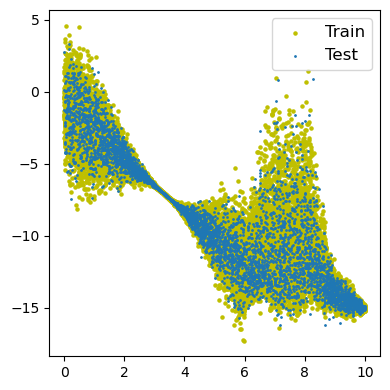

In [227]:
# Show the data (if requested).
if plotData:
    if saveData:
        saveDataFile = 'regress_data.png'
    else:
        saveDataFile = ''
    plot_data(x_train, y_train, x_test, y_test,
        saveFile=saveDataFile)

## Model Setup

In [228]:
# Build, compile, and train the models.
n_inputs = x_train.shape[-1]
n_outputs = y_train.shape[-1]

mDict = {}
iExp = 0
for mtype in MODEL_TYPE_LIST:
    mOpts = modelOpts.copy()
    mOpts['loss_type'] = mtype

    uq_nnet = NeuralNetwork(n_inputs, n_outputs, mOpts)
    uq_nnet.compile(runOpts)

    if showSummary:
        uq_nnet.model.summary()

    uq_nnet.train(x_train, y_train, validation=(x_test, y_test))

    pred_span = uq_nnet.use(x_span, returnType='mc')
    pred_mean, pred_std, pred_median = uq_nnet.use(x_span, returnType='uq3')

    pred_test_ens = uq_nnet.use(x_test, returnType='mc')
    pred_test_mean, pred_test_std = uq_nnet.use(x_test, returnType='uq')

    mmDict = {
        'model': uq_nnet,
        'model_color': MODEL_COLOR_LIST[iExp],
        'pred_span': pred_span,
        'pred_span_mean': pred_mean,
        'pred_span_median': pred_median,
        'pred_span_std': pred_std,
        'pred_test_ens': pred_test_ens,
        'pred_test_mean': pred_test_mean,
        'pred_test_std': pred_test_std}
    mDict[mtype] = mmDict
    iExp += 1


NeuralNetwork setup with 1 inputs and 1 outputs
Model: "PDP_NORM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
___________________________________________

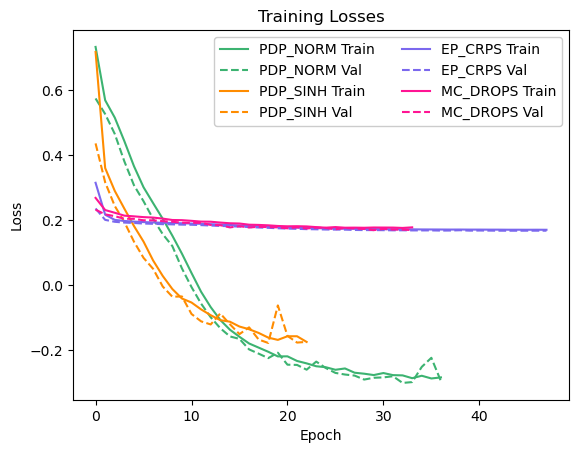

In [229]:
# Plot the loss
if plotLoss:
    if saveLoss:
        saveLossFile='regress_loss.png'
    else:
        saveLossFile=''
    plot_loss_dict(mDict, saveFile=saveLossFile)

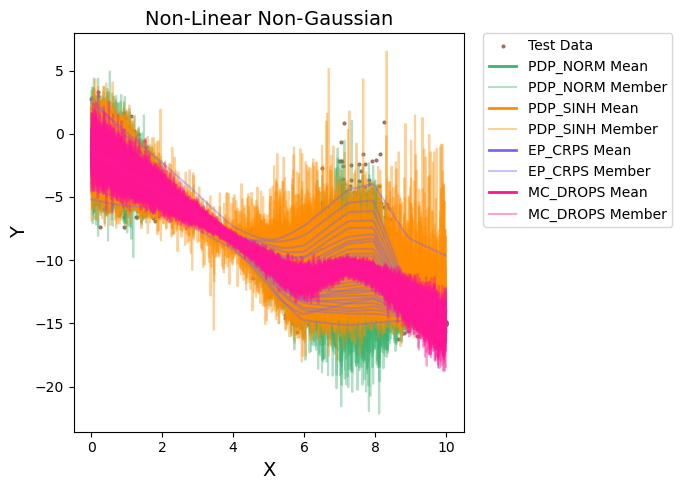

In [230]:
# Plot the predictions
if plotPredictions:
    if savePredictions:
        savePredFile='regress_predictions.png'
    else:
        savePredFile=''
    plot_preds_dict(x_span, x_test, y_test, mDict,
        ensAlpha=0.4, saveFile=savePredFile, 
        title=yTitle)

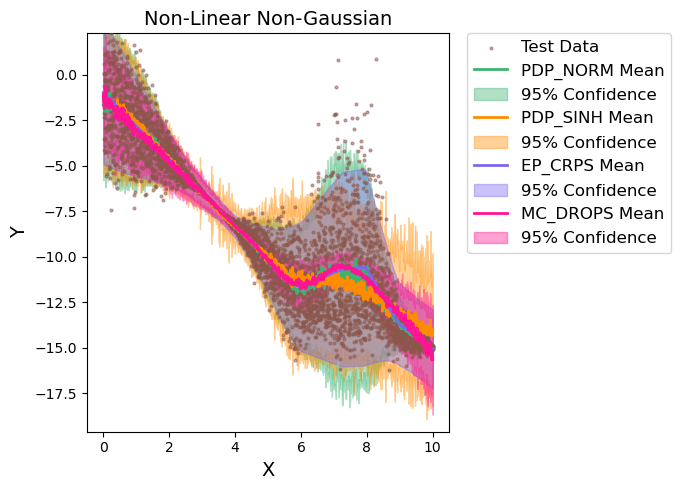

In [231]:
# Plot the uncertainty (95% range)
if plotUQ:
    if saveUQ:
        saveUQFile='regress_predictions_uq.png'
    else:
        saveUQFile=''
    plot_uq_dict(x_span, x_test, y_test, mDict,
        saveFile=saveUQFile, title=yTitle)

## Single Model Evaluation Plots
In order to evaluate the model, let's create predictions over the range of testing data so that we can create line plots.  <br>
- For ensemble approaches, we obtain the predictions for all of the ensemble members (pred_span).  If the model does not have ensemble members, then None is returned. 
- For all, we obtain the prediction mean (pred_mean) and the standard deviation the model determined for uncertainty quantification (pred_std).  If the model does not quantify uncertainty, then pred_std is None.
- For all, we obtain the test predictions and standard deviation matching the x-test values.

### Continuous Rank Probability Score
The CRPS is based on the cumulative distribution function (CDF).  Here we show the CDF of the data and the predictions, along with the scores in the labels.

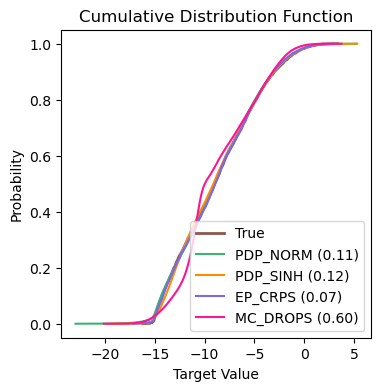

In [232]:
if plotCRPS:
    if saveCRPS:
        fileCRPS = 'regress_cdf_crps.png'
    else:
        fileCRPS = ''
    plot_crps_dict(y_test, mDict, saveFile=fileCRPS)

### Attributes Diagram
The attributes diagram is a way to evaluate the central predictions from the model.  For regression tasks:
- x-axis: central predicted value (in this case the mean) grouped into bins
- y-axis: corresponding true value for the predicted points

/Users/kdhaynes/Anaconda3/envs/mlsound/lib/python3.9/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


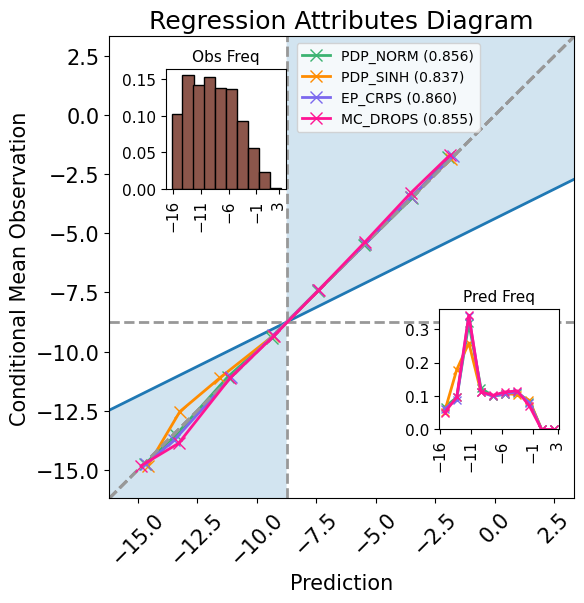

In [233]:
if plotAttributes:
  rDict = {}
  spread_bins = None
  for mtype in MODEL_TYPE_LIST:
    mmDict = mDict[mtype]
    pred_test = mmDict['pred_test_mean']
    eDict = get_attributes_points(
        y_test, pred_test,
        mean_val=y_train.mean(),
        showR2=r2ShowAttr,
        verbose=verboseAttr)
    rDict[mtype] = eDict

  if saveAttributes:
    fileAttributes = 'regress_attr_diagram.png'
  else:
    fileAttributes = ''
  plot_attributes_diagram_dict(
      rDict, 
      labelx_rotate=45,
      legend_show=True,
      plot_obs_hist=True, 
      plot_pred_hist=True,
      save_file=fileAttributes,
      show_background=True,
      title='Regression Attributes Diagram')

### Spread-Skill Diagram
The spread-skill diagram is a way to evaluate the uncertainty predictions, by plotting how the uncertainty matches the actual error.

/var/folders/k1/lds3ffz979sbsf1wz08vbt38001flf/T/ipykernel_71922/2303792199.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


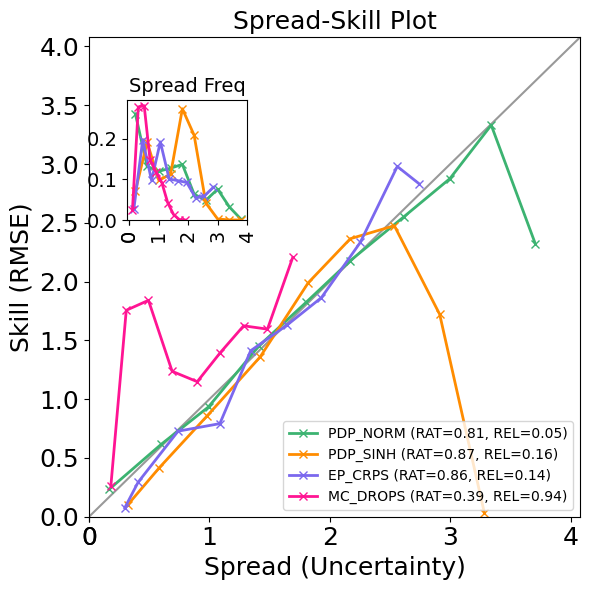

In [234]:
if plotSpreadSkill:
  sDict = {}
  for mName in MODEL_TYPE_LIST:
      mmDict = mDict[mName]
      pred_test_mean = mmDict['pred_test_mean']
      pred_test_std = mmDict['pred_test_std']

      ssDict = get_spread_skill_points(\
        y_test, pred_test_mean, 
        pred_test_std, 
        showR2=r2ShowSpreadSkill, 
        verbose=verboseSpreadSkill)
      sDict[mName] = ssDict

  if saveSpreadSkill:
    fileSpreadSkill = 'regress_ss.png'
  else:
    fileSpreadSkill = ''
  plot_spread_skill_dict(
      sDict,
      plot_hist=True,
      save_file=fileSpreadSkill)
  

### Discard Test
The discard test shows whether or not the error decreases as the most uncertain predictions are removed.

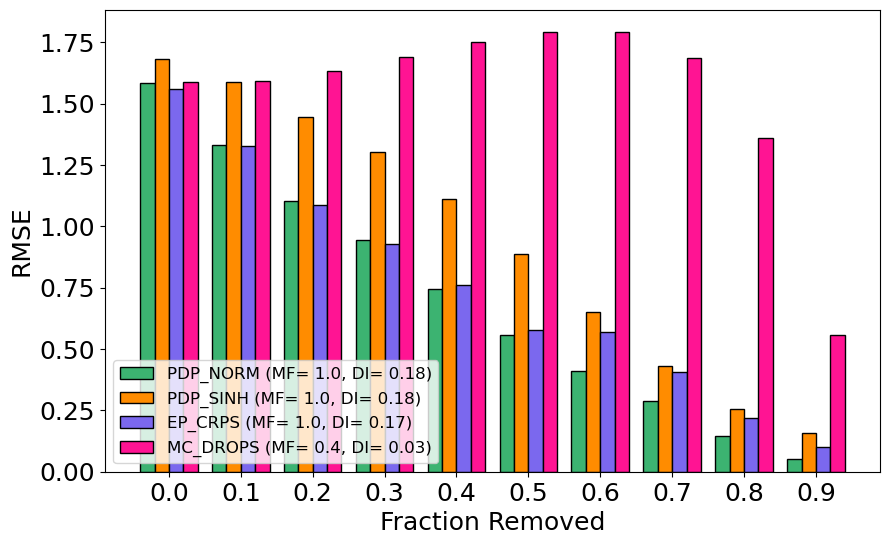

In [235]:
if plotDiscard:
    dDict = {}
    for mName in MODEL_TYPE_LIST:
        mmDict = mDict[mName]
        pred_test_mean = mmDict['pred_test_mean']
        pred_test_std = mmDict['pred_test_std']

        ddDict = get_discard_points(\
          y_test, pred_test_mean, 
          pred_test_std)
        dDict[mName] = ddDict

    if saveDiscard:
      saveDiscardFile = 'regress_discard.png'
    else:
      saveDiscardFile = ''
    plot_discard_dict(dDict, legend_size=12, save_file=saveDiscardFile)

### PIT Histogram
The probability integral transform (PIT) diagram is useful for regression tasks that predict uncertainty estimates for ensuring that the range of uncertainty is appropriate.  Ideally, the histogram is uniform, indicating that the observed value fall equally into quantiles of the predicted distribution.  If  the histogram has higher values in the center bins, then the observations occur too frequently in the middle of the predicted distribution, so the model uncertainty estimate is too broad and the model is overspread or "underconfident".  If the histogram has high values in the end bins, then the observations occur too often on the outer edges (or even outside) of the predicted uncertainty, indicating the model is underspread or "overconfident".  

Since the PIT histogram should be uniform, a single score can be determined to evaluate the uniformness in a quantitative manner.  Following Nipen et al. (2011), a calibration deviation metric, D, can be calculated, where low values are better.  Because sampling error causes even perfectly calibrated estimates to have non-uniform PIT histograms, an expected calibration deviation, E, can also be calculated, which gives an estimate for what an acceptable calibration metric should be at or below.

Here we show the PIT diagram, with all of the models shown on a single figure.  The grey dashed line at 0.1 indicates the value that all the PIT bins should be at.  The calibration metric, D, is shown in the legend.  

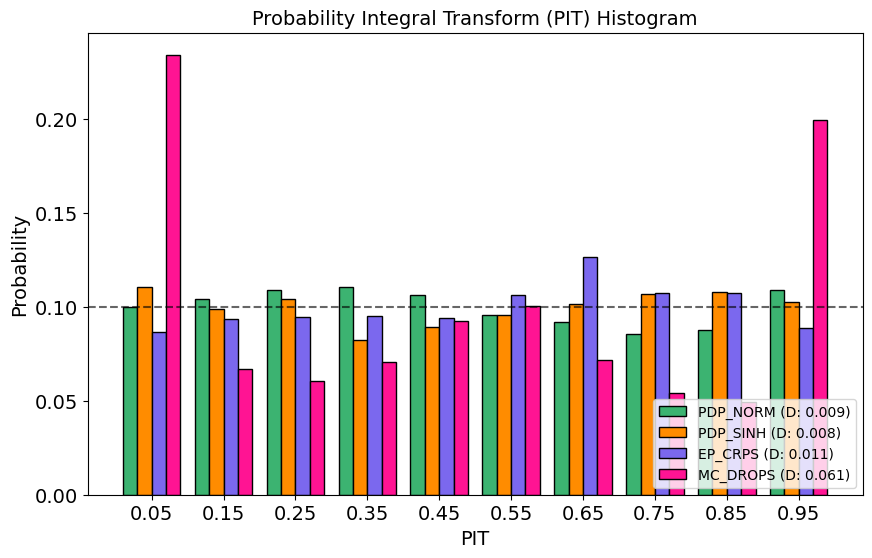

In [236]:
if plotPIT:
    pDict = {}
    for mName in MODEL_TYPE_LIST:
        mmDict = mDict[mName]
        pred_test_ens = mmDict['pred_test_ens']
        ppDict = get_pit_points_ens(y_test, pred_test_ens)

        # NOTE: To not use the ensemble members, but 
        # instead assume a normal distribution from
        # the mean and standard deviation,
        # uncomment below.
        # pred_test_mean = mmDict['pred_test_mean']
        # pred_test_std = mmDict['pred_test_std']
        # ppDict = get_pit_points(\
        #     y_test, pred_test_mean, 
        #     pred_test_std)
        pDict[mName] = ppDict

    if savePIT:
        savePITFile = 'regress_pit.png'
    else:
        savePITFile = ''
    plot_pit_dict(pDict, save_file=savePITFile)

## Model Comparitive Evaluation Scores

In [237]:
if modelCompEval:
    evalDict = {}
    for mName in MODEL_TYPE_LIST:
        mmDict = mDict[mName]
        yens = mmDict['pred_test_ens']
        ypred = mmDict['pred_test_mean']
        ystd = mmDict['pred_test_std']

        # mcrps = crps_score(y_test, yens, plotCRPS=False)
        mcrpse = crps_ensemble(y_test, yens)
        
        relDict = get_attributes_points(y_test, ypred,
            showR2=False, verbose=False)
        msess = relDict['attr_msess']

        ssDict = get_spread_skill_points(y_test, ypred, ystd, 
            showR2=False, verbose=False)
        ssRatio = ssDict['ss_ratio']
        ssReliability = ssDict['ss_reliability']

        dDict = get_discard_points(y_test, ypred, ystd)
        dmf = dDict['discard_mf']
        dimprv = dDict['discard_imprv']
        
        pitDict = get_pit_points_ens(y_test, yens)
        # pitDict = get_pit_points(y_test, ypred, ystd)
        pitd = pitDict['pit_dvalue']

        if 'pdp' in mName:
            mign = ignorance_score(y_test, ypred, ystd, plotPDF=False)
        else:
            mign = ignorance_score_ens(y_test, yens)

        mscores = {}
        mscores['MSESS'] = msess
        mscores['SSRAT'] = ssRatio
        mscores['SSREL'] = ssReliability
        mscores['MF'] = dmf
        mscores['DI'] = dimprv
        mscores['PITD'] = pitd
        mscores['CRPS'] = mcrpse.mean()
        mscores['IGN'] = mign
        evalDict[mName] = mscores

    evalDF = DataFrame(evalDict)
    display(evalDF.reindex(list(mscores.keys())))
    # display(evalDF)


,pdp_norm,pdp_sinh,ep_crps,mc_drops
CRPS,0.732927,0.769772,0.699180,0.859381
MSESS,0.856025,0.837491,0.860017,0.854861
SSRAT,0.805454,0.865868,0.857403,0.386749
SSREL,0.049900,0.159771,0.137570,0.938944
MF,1.000000,1.000000,1.000000,0.444444
DI,0.179911,0.178275,0.167700,0.028556
PITD,0.008726,0.008253,0.011345,0.060777
IGN,1.675938,2.288695,1.979639,4.631967
